In [1]:
library(ggplot2, quietly = T)
library(dplyr, quietly = T)
library(Matrix, quietly = T)
library(data.table, quietly = T)
library(stringr, quietly = T)
library(patchwork, quietly = T)
library(glue, quietly = T)
library(ggforce, quietly = T)
library(vcfR, quietly = T)
library(purrr, quietly = T)
library(magrittr, quietly = T)
library(parallel, quietly = T)
library(ggpubr, quietly = T)
library(ggraph, quietly = T)
library(tidygraph, quietly = T)
library(extraDistr, quietly = T)
library(ggrepel, quietly = T)
library(IRdisplay, quietly = T)
library(igraph, quietly = T)
library(ggridges, quietly = T)
library(ggtree, quietly = T)
# library(numbat, quietly = T)
# R.utils::sourceDirectory('~/Numbat/R')
options(repr.matrix.max.cols=30, repr.matrix.max.rows=20)
options(repr.vector.max.items = 50)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names



Attaching package: ‘tidygraph’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘extraDistr’


The following object is masked from ‘package:purrr’:

    rdunif



Attaching package: ‘igraph’


The following object is masked from ‘package:t

In [2]:
devtools::load_all('~/numbat')

ℹ Loading numbat

Registered S3 method overwritten by 'dendextend':
  method     from 
  rev.hclust vegan

Warning message:
“replacing previous import ‘Matrix::expand’ by ‘ggtree::expand’ when loading ‘numbat’”


In [3]:
con = readRDS('~/paper_data/conos_objects/conos_WASHU.rds')

In [4]:
cell_annot = fread('~/paper_data/cell_annotations/cell_annot_WASHU.tsv') %>% 
    mutate(sample_id = str_replace(sample_id, '-', '_')) %>%
    mutate(sample_id = ifelse(sample_id == '57075_Pre_transplant', '57075_Primary', sample_id)) %>%
    mutate(cell = paste0(sample_id, '_', barcode)) %>% 
    split(.$sample_id)

In [5]:
patient = '27522'
samples = c('27522_Primary', '27522_Remission', '27522_Relapse_1', '27522_Relapse_2')
df = list()
count_mat = list()
for (sample in samples) {
    
    df[[sample]] = fread(glue('~/paper_data/processed/{sample}_allele_counts.tsv.gz'), sep = '\t', nThread = 4) %>% 
        filter(CHROM %in% c(1:22)) %>%
        mutate(CHROM = factor(as.integer(CHROM)))
    count_mat[[sample]] = t(con$samples[[sample]]$misc$rawCounts)
    
}

In [5]:
df_all = df %>% bind_rows() %>% filter(GT %in% c('0|1', '1|0'))

In [6]:
chrom_sizes = fread('~/ref/hg38.chrom.sizes.txt') %>% setNames(c('CHROM', 'size')) %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>% 
    filter(CHROM %in% 1:22)

# 27522

## All samples

In [8]:
library(numbat)

In [146]:
R.utils::sourceDirectory('~/Numbat/R')

patient = '27522'
samples = c('27522_Primary', '27522_Remission', '27522_Relapse_1', '27522_Relapse_2')

out_dir = glue('~/paper_data/numbat_out/{patient}')
nb = Numbat$new(out_dir, i = 2)

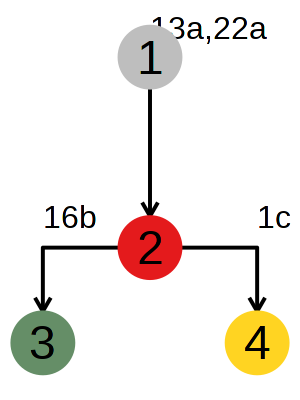

In [64]:
options(repr.plot.width = 1.5, repr.plot.height = 2, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

nb$mut_graph %>% plot_mut_history(horizontal = F)

In [36]:
normal_cells = bind_rows(cell_annot[samples]) %>% filter(cell_type != 'Plasma') %>% pull(cell)
normal_cells = intersect(colnames(count_mat_all), normal_cells)

In [37]:
haplo_truth = nb$bulk_subtrees %>% filter(sample == 2) %>%
    filter(CHROM %in% c(13, 22)) %>%
    filter(DP >= 5) %>%
    filter(!is.na(AD)) %>%
    mutate(haplo_truth = ifelse(AR < 0.5, 'minor', 'major')) %>%
    select(CHROM, snp_id, haplo_truth) 

In [39]:
cell = '27522_Relapse_2_AAACCTGGTACTCAAC-1'

df_sim = df_all %>% 
    filter(cell %in% normal_cells) %>%
    mutate(CHROM = as.integer(CHROM)) %>%
    inner_join(haplo_truth, by = c('snp_id', 'CHROM')) %>%
    # filter(cell == UQ(cell)) %>%
    arrange(cell) %>%
    mutate(
        DP = 2*DP,
        AD = ifelse(haplo_truth == 'major', AD*2, AD)
    )

In [40]:
count_mat_all = count_mat %>% Reduce('cbind', .) %>% .[,normal_cells]

In [16]:
library(logger)

In [ ]:
bind_rows(cell_annot[samples]) %>% filter()

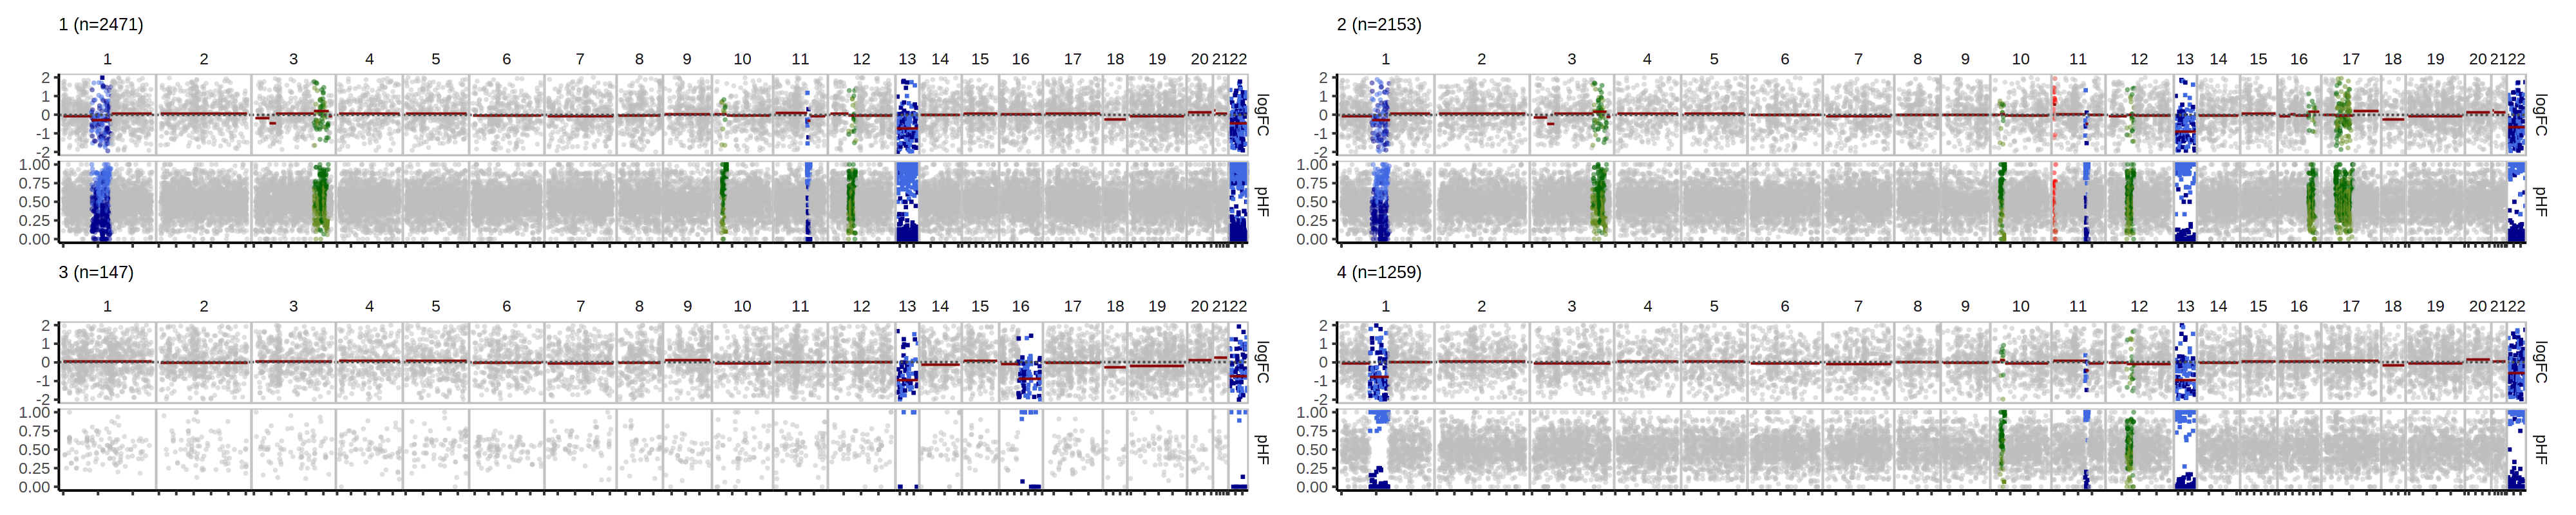

In [179]:
options(repr.plot.width = 20, repr.plot.height = 4, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

plot_bulks(nb$bulk_subtrees, ncol = 2, min_LLR = 40)

In [336]:
nb$joint_post %>% count(cnv_state)

cnv_state n    
1 amp        4968
2 del       12420
3 loh        4968

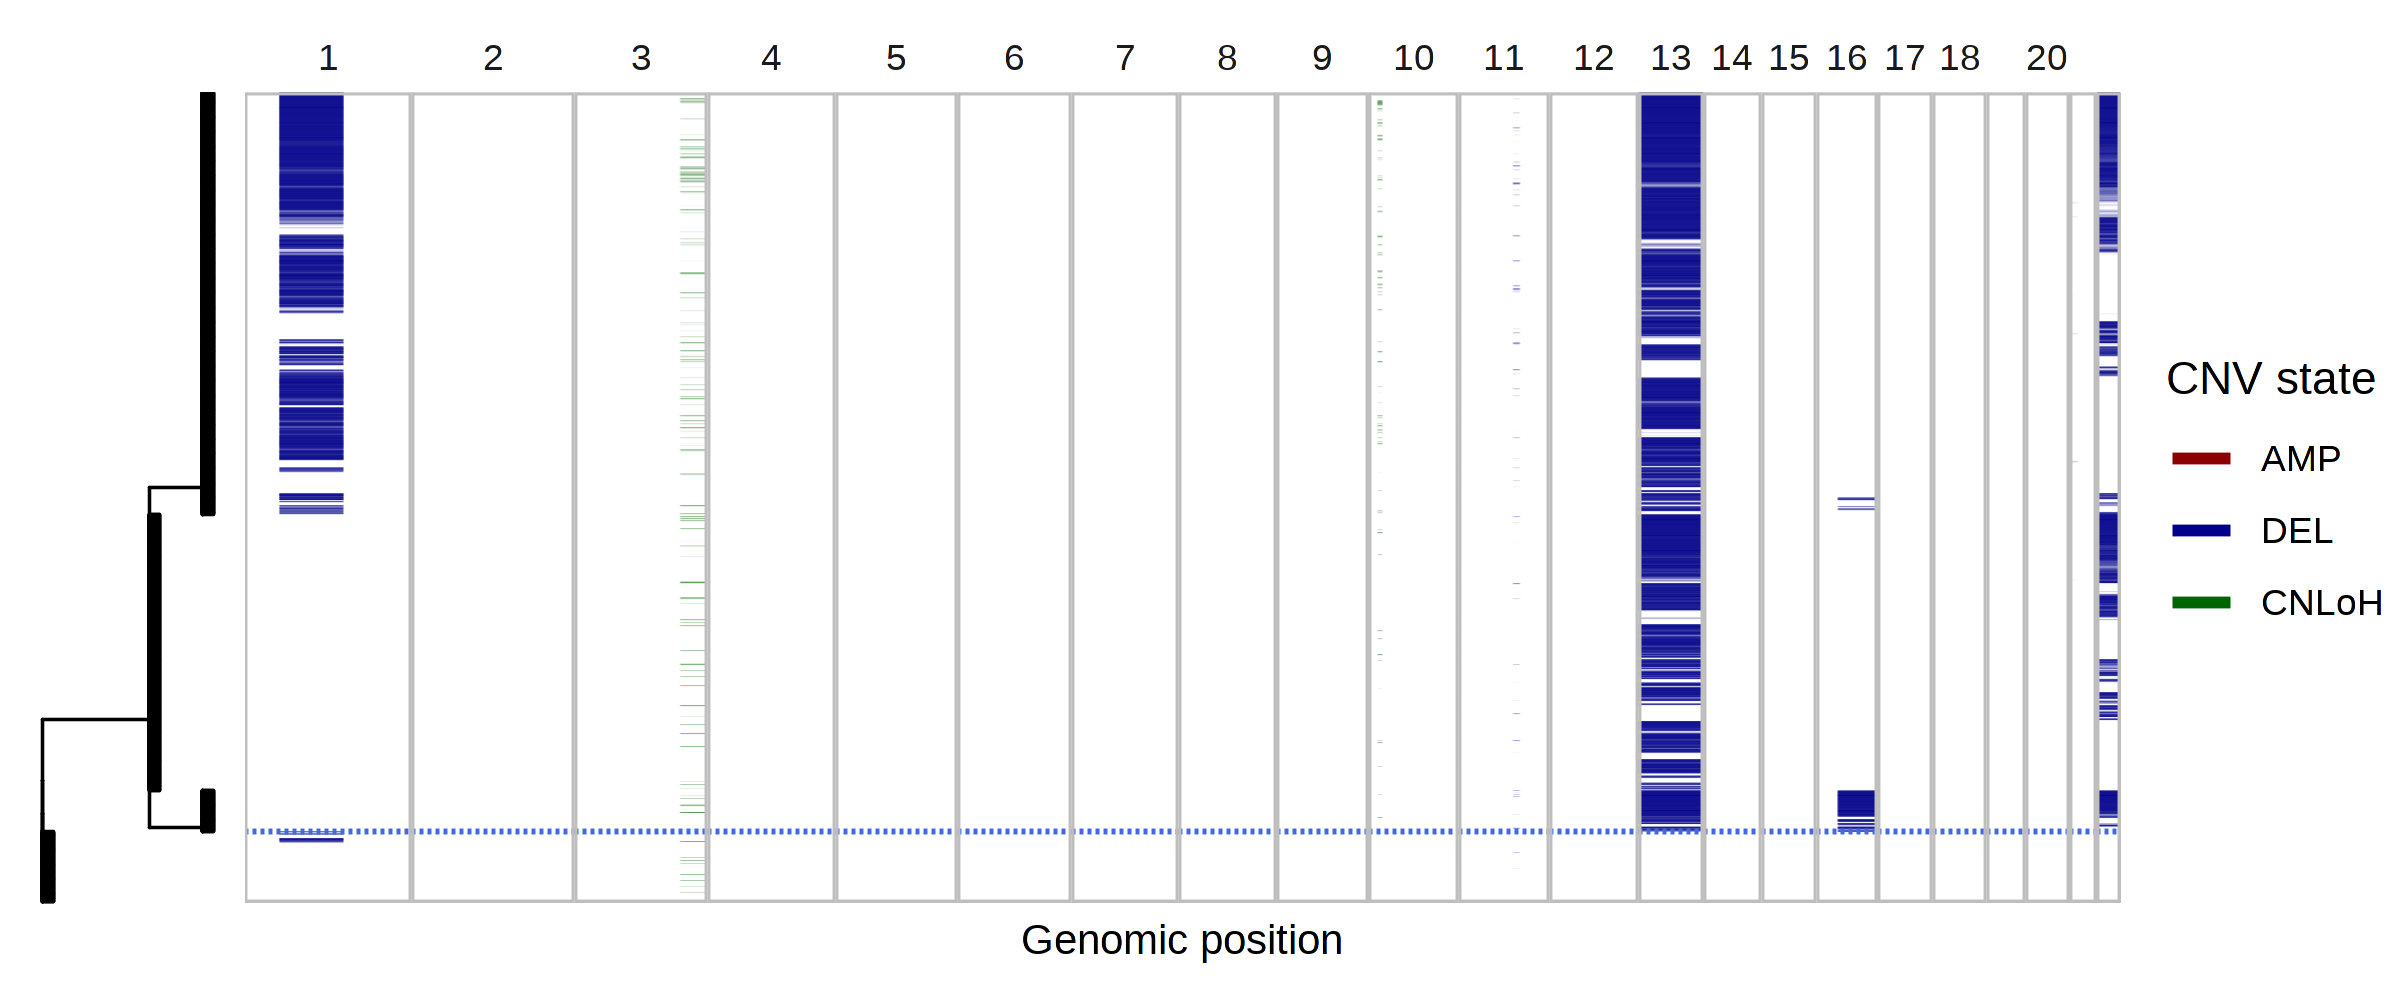

In [169]:
options(repr.plot.width = 7.5, repr.plot.height = 3.3, repr.plot.res = 300)
R.utils::sourceDirectory('~/Numbat/R')

p = nb$plot_phylo_heatmap(
        tip_length = 0.2,
        p_min = 0.9,
        line_width = 0.05,
        clone_bar = F,
        branch_width = 0.3,
        tree_height = 1.5,
        pal_clone = c('gray', RColorBrewer::brewer.pal(n = 8, 'Set1'))
    ) &
theme(
    plot.background = element_rect(fill = "transparent", color = NA),
    legend.position = ''
)

p = ggrastr::rasterize(p, layers = 'Segment', dpi = 300)

do_plot(p, '27522_phylogeny', w = 8, h = 3.3)

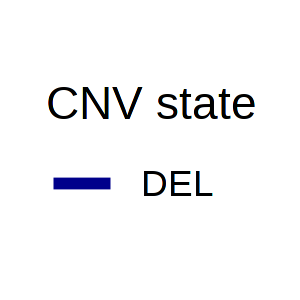

In [339]:
p = plot_phylo_heatmap(
        nb$gtree,
        nb$joint_post %>% filter(cnv_state == 'del'),
        nb$segs_consensus,
        tip_length = 0.2,
        p_min = 0.9,
        line_width = 0.05,
        clone_bar = F,
        branch_width = 0.3,
        tree_height = 1.5,
        pal_clone = c('gray', RColorBrewer::brewer.pal(n = 8, 'Set1'))
    )

get_legend(p) %>% as_ggplot() %>%
do_plot('del_legend2', 1, 1)

In [166]:
load('~/numbat/data/acen.rda')

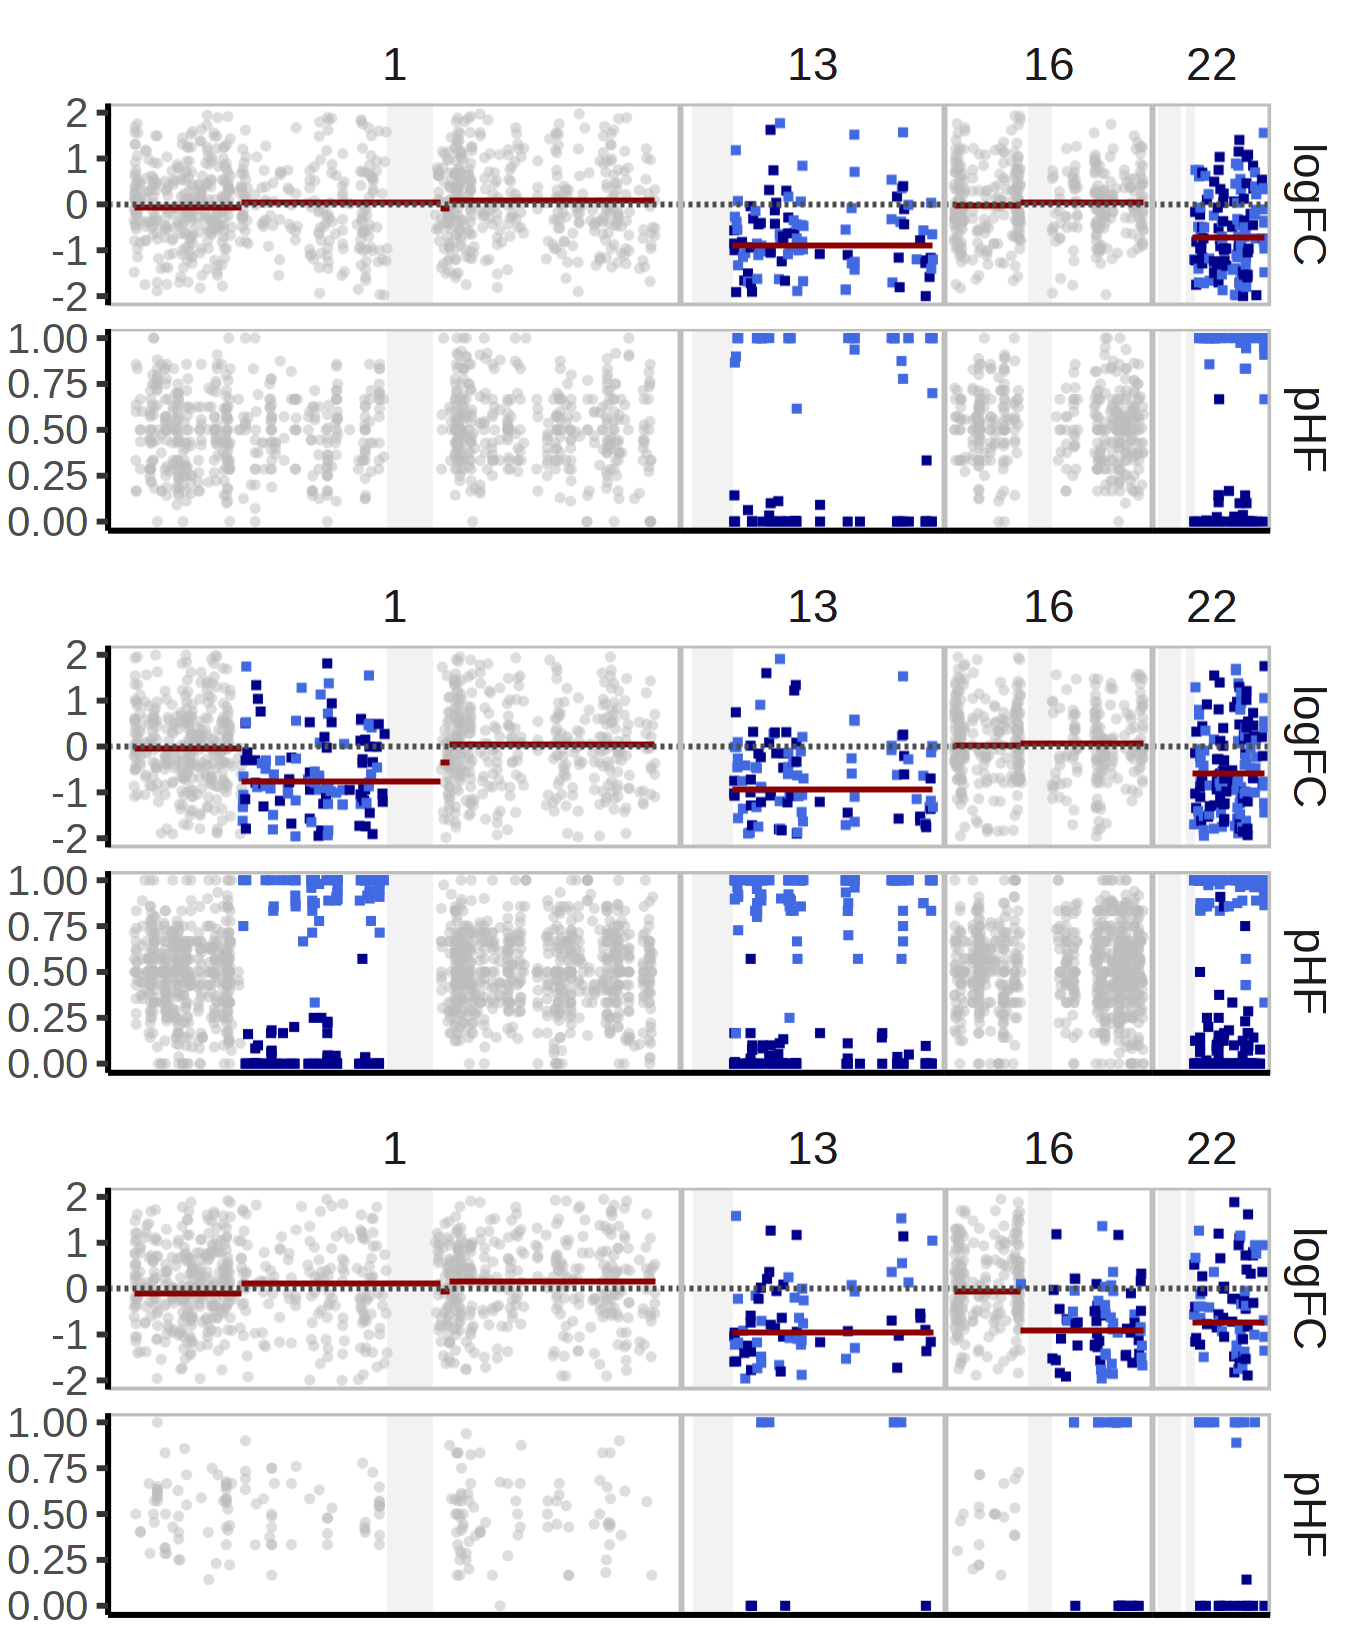

In [481]:
options(repr.plot.width = 4.5, repr.plot.height = 5.5, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

p = nb$bulk_clones %>%
    filter(sample %in% c(2,3,4)) %>%
    mutate(sample = factor(sample, c(2,4,3))) %>%
    filter(CHROM %in% c(1,13,16,22)) %>%
    plot_bulks(ncol = 1, min_depth = 6, legend = F, phi_mle = TRUE, title = F, raster = T) &
    theme(
        strip.text = element_text(size = 11),
        axis.text.y = element_text(size = 10),
        panel.spacing.y = unit(2, 'mm'),
        plot.margin = margin(1, 0, 1, 0, unit = 'mm')
    )

do_plot(p, '27522_segs', 4.5, 5.5)

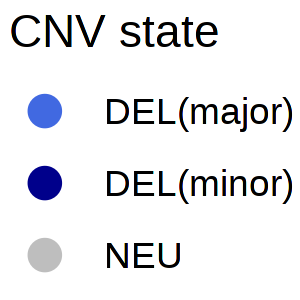

In [164]:
options(repr.plot.width = 1.2, repr.plot.height = 2.2, repr.plot.res = 300)

p = data.frame(
    state = c('DEL_up', 'DEL_down', 'NEU')
) %>%
mutate(
    state = state %>% str_replace('_up', '(major)') %>% 
        str_replace('_down', '(minor)')
) %>%
ggplot(
    aes(x = state, y = state, color = state)
) +
geom_point() +
scale_color_manual(
    values = setNames(cnv_colors, names(cnv_colors) %>% 
        str_replace('_up', '(major)') %>% 
        str_replace('_down', '(minor)') %>%
        str_replace('loh', 'CNLoH') %>%
        str_replace('bamp', 'BAMP') %>%
        str_replace('amp', 'AMP') %>%
        str_replace('del', 'DEL') %>%
        str_replace('neu', 'NEU')
    ),
    limits = force
) +
theme_classic() +
guides(color = guide_legend(override.aes = aes(size = 3), title = 'CNV state'))

get_legend(p) %>% as_ggplot %>%
do_plot('del_legend', 1, 1)

### CopyKat

In [22]:
patient = '27522'

In [55]:
CNA.test = fread(glue('/home/tenggao/copykat_results/{patient}/27522_copykat_CNA_results.txt'))
pred.test = fread(glue('/home/tenggao/copykat_results/{patient}/{patient}_copykat_prediction.txt'))

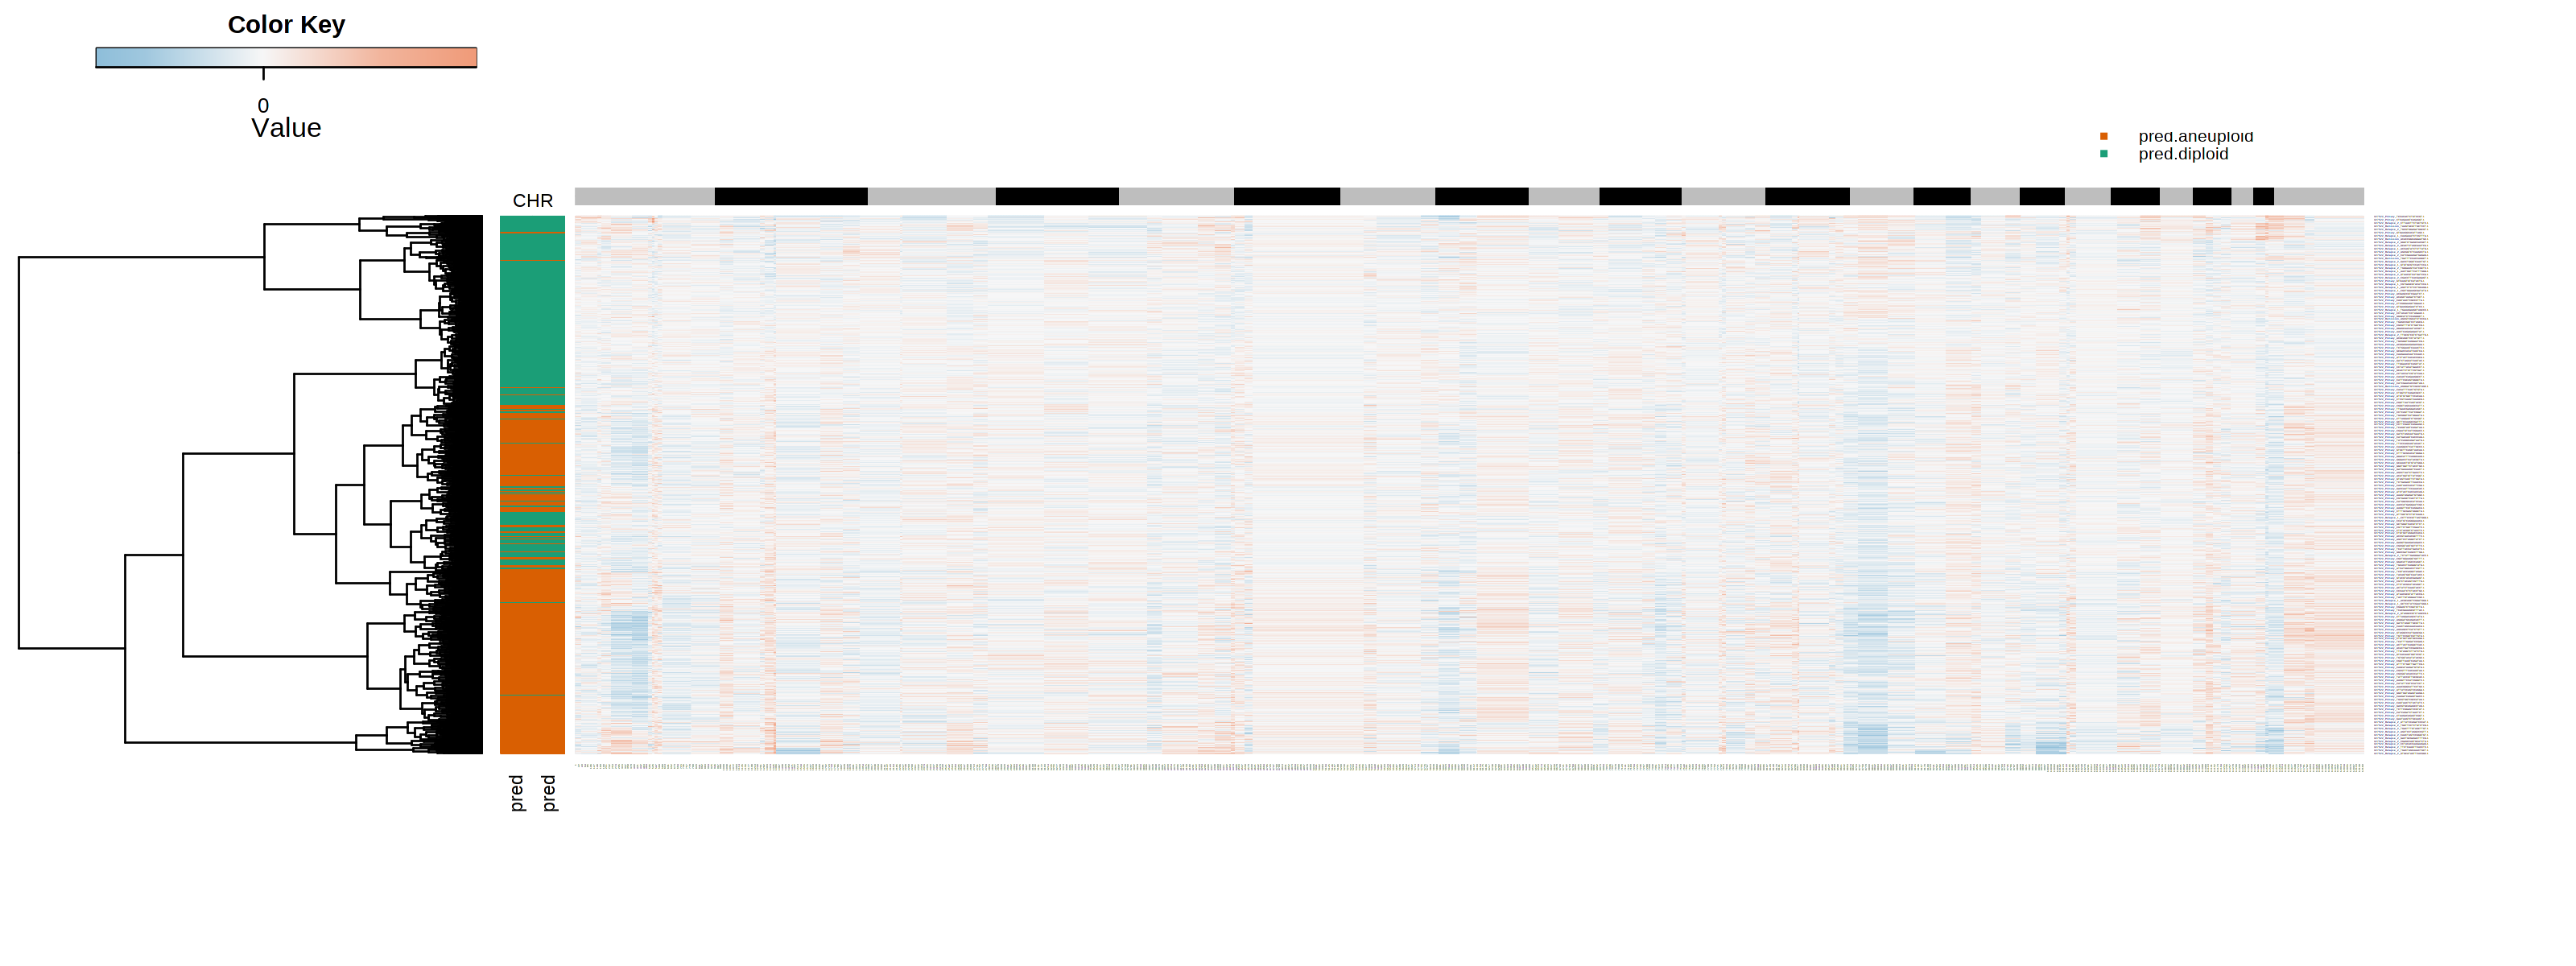

In [58]:
options(repr.plot.width = 16, repr.plot.height = 6, repr.plot.res = 200)

my_palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 3, name = "RdBu")))(n = 999)

chr <- as.numeric(CNA.test$chrom) %% 2+1
rbPal1 <- colorRampPalette(c('black','grey'))
CHR <- rbPal1(2)[as.numeric(chr)]
chr1 <- cbind(CHR,CHR)

rbPal5 <- colorRampPalette(RColorBrewer::brewer.pal(n = 8, name = "Dark2")[2:1])
com.preN <- pred.test$copykat.pred
pred <- rbPal5(2)[as.numeric(factor(com.preN))]

cells <- rbind(pred,pred)
col_breaks = c(seq(-1,-0.4,length=50),seq(-0.4,-0.2,length=150),seq(-0.2,0.2,length=600),seq(0.2,0.4,length=150),seq(0.4, 1,length=50))

copykat::heatmap.3(t(CNA.test[,4:ncol(CNA.test)]),dendrogram="r",
        distfun = function(x) parallelDist::parDist(x,threads =4, method = "euclidean"), hclustfun = function(x) hclust(x, method="ward.D2"),
        ColSideColors=chr1,RowSideColors=cells,Colv=NA, Rowv=TRUE,
        notecol="black",col=my_palette,breaks=col_breaks, key=TRUE,
        keysize=1, density.info="none", trace="none",
        cexRow=0.1,cexCol=0.1,cex.main=1,cex.lab=0.1,
        symm=F,symkey=F,symbreaks=T,cex=1, cex.main=4, margins=c(10,10))

legend("topright", paste("pred.",names(table(com.preN)),sep=""), pch=15,col=RColorBrewer::brewer.pal(n = 8, name = "Dark2")[2:1], cex=0.6, bty="n")

### InferCNV

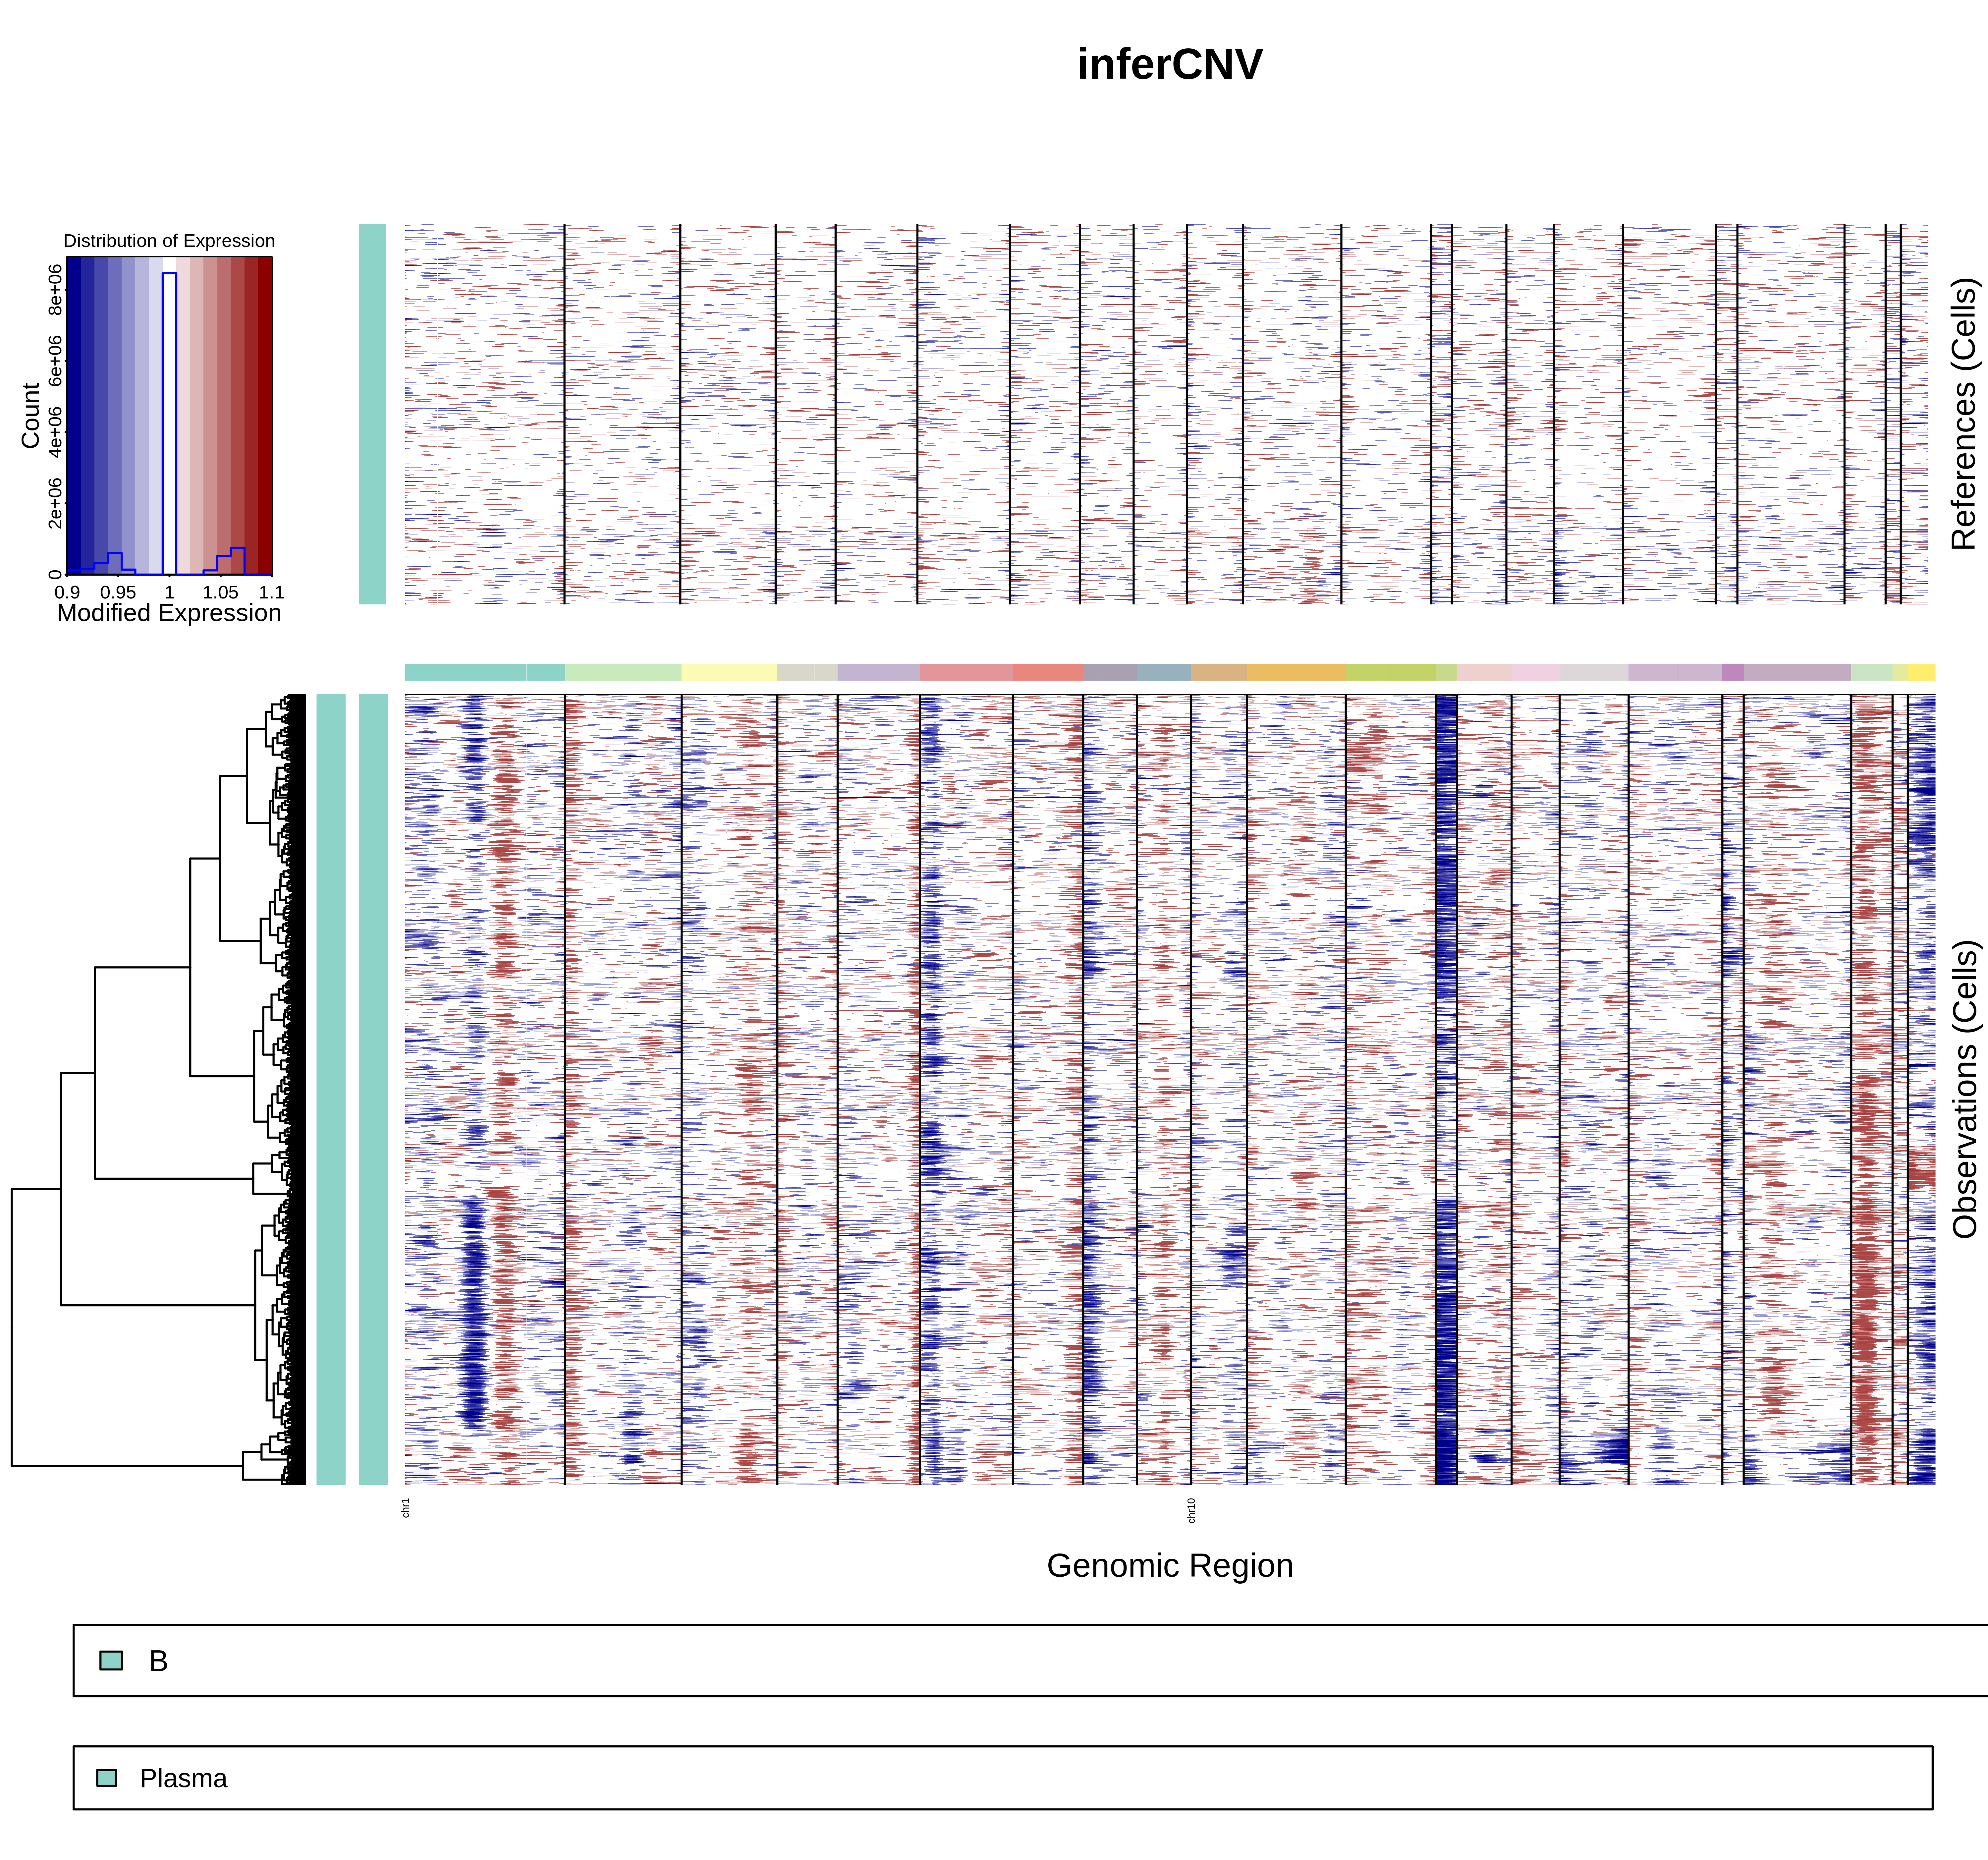

In [1171]:
display_png(file = glue('/home/tenggao/inferCNV/{patient}/infercnv.png'), width = 800)

### DE

### GSEA

In [11]:
library(liger)

h_gene_sets = msigdbr::msigdbr(species = "human", category = "H") %>%
    split(.$gs_name) %>%
    lapply(function(x) {unique(x$gene_symbol)})

names(h_gene_sets) = str_remove(names(h_gene_sets), 'HALLMARK_')


Attaching package: ‘liger’


The following object is masked _by_ ‘.GlobalEnv’:

    gsea




#### Plotting

In [357]:
gsea = function (values, geneset, q.val, ypos = 'top', power = 1, rank = FALSE, weight = rep(1, 
    length(values)), n.rand = 10000, plot = TRUE, main = "", 
    return.details = FALSE, quantile.threshold = min(100/n.rand, 
        0.1), random.seed = 1, mc.cores = 1, y_nudge = 0.025) 
{
    set <- names(values) %in% geneset
    vo <- order(values, decreasing = TRUE)
    values <- values[vo]
    set <- set[vo]
    weight <- weight[vo]
    if (rank) {
        es <- weight
    }
    else {
        es <- (abs(values)^power) * weight
    }
    eso <- es
    es[set] <- es[set]/sum(es[set])
    es[!set] <- -1 * es[!set]/sum(es[!set])
    es <- es * length(values)
    sv <- cumsum(es)
    sv.p <- max(0, max(sv))
    sv.n <- min(0, min(sv))
    p.x.p <- which.max(sv)
    p.x.n <- which.min(sv)
    if (mc.cores > 1) {
        rvll <- parallel::mclapply(1:mc.cores, function(i) {
            set.seed(random.seed + i)
            gseaRandCore(set, eso, nsamples = ceiling(n.rand/mc.cores))
        }, mc.preschedule = TRUE, mc.cores = mc.cores)
        rvl <- list(p = unlist(lapply(rvll, function(x) x$p)), 
            n = unlist(lapply(rvll, function(x) x$n)))
    }
    else {
        set.seed(random.seed)
        rvl <- liger:::gseaRandCore(set, eso, nsamples = n.rand)
    }
    p.v.p <- (sum(rvl$p >= sv.p) + 1)/(length(rvl$p + 1))
    p.v.n <- (sum(rvl$n <= sv.n) + 1)/(length(rvl$n + 1))
    p.x <- ifelse(p.v.p < p.v.n, p.x.p, p.x.n)
    p.v <- ifelse(p.v.p < p.v.n, p.v.p, p.v.n)
    if (p.v.p < p.v.n) {
        q.thr <- stats::quantile(rvl$p, p = (1 - quantile.threshold))
    }
    else {
        q.thr <- stats::quantile(rvl$n, p = quantile.threshold)
    }
    if (plot) {
        l <- graphics::layout(matrix(c(1, 2, 3), 3, 1, byrow = T), 
            c(1, 1, 1), c(1.4, 0.3, 0.9), FALSE)
        graphics::par(mar = c(0.1, 3.5, 1.5, 0.5), mgp = c(2, 
            0.65, 0), cex = 0.9)
        plot(c(1:length(sv)), sv, type = "l", ylab = "Score", 
            xaxt = "n", xlab = "", main = main, xaxs = "i", xlim = c(1, 
                length(sv)), col = "darkblue", cex.main=1.5)
        graphics::segments(p.x, 0, p.x, sv[p.x], col = 2, lty = 2)
        graphics::segments(0, sv[p.x], p.x, sv[p.x], col = 2, 
            lty = 2)
        qv.p <- stats::quantile(rvl$p, p = 1 - 10^(-1 * seq(1, 
            round(log10(length(rvl$p))))))
        qv.n <- -1 * stats::quantile(-1 * rvl$n, p = 1 - 10^(-1 * 
            seq(1, round(log10(length(rvl$n))))))
        graphics::abline(h = c(qv.p, qv.n), lty = 3, col = 8)
        graphics::abline(h = 0, lty = 2, col = 8)
        xpos <- "right"
        if (p.x > round(length(sv)/2)) {
            xpos <- "left"
        }
        
        if (q.val == 0) {
            label = "q < 2.2e-16"
        } else {
            label = paste("q <", format(q.val, digits = 3))
        }
        
        graphics::legend(x = ifelse(sv[round(length(sv)/2)] > 
            sv[p.x], paste(ypos, xpos, sep = ""), paste(ypos, 
            xpos, sep = "")), bty = "n", legend = label, inset=c(y_nudge,0))
        graphics::par(mar = c(0.1, 3.5, 0.1, 0.5))
        mset <- set
        mset[!set] <- NA
        plot(mset, xaxt = "n", ylim = c(0, 1), xlab = "", ylab = "", 
            xaxs = "i", yaxt = "n", type = "h", col = "blue")
        graphics::abline(v = p.x, col = 2, lty = 2)
        graphics::box()
        graphics::par(mar = c(0.5, 3.5, 0.1, 0.5))
        plot(values, ylab = "logFC", xaxs = "i", type = "h", 
            xaxt = "n", col = "darkblue")
#         graphics::legend(x = "topright", bty = "n", legend = paste("edge value = ", 
#             format(values[p.x], digits = 2)))
        graphics::abline(v = p.x, col = 2, lty = 2)
        graphics::box()
    }
    if (return.details) {
        rv <- c(p.val = p.v, edge.score = as.numeric(sv[p.x]), 
            edge.value = as.numeric(values[p.x]), scaled.score = as.numeric(sv[p.x]/q.thr))
        return(rv)
    }
    else {
        return(p.v)
    }
}

In [73]:
nb$clone_post %>% count(clone_opt, GT_opt)

clone_opt GT_opt      n   
1 1                      309
2 2         13a,22a      748
3 3         13a,22a,16b  148
4 4         13a,22a,1b  1266

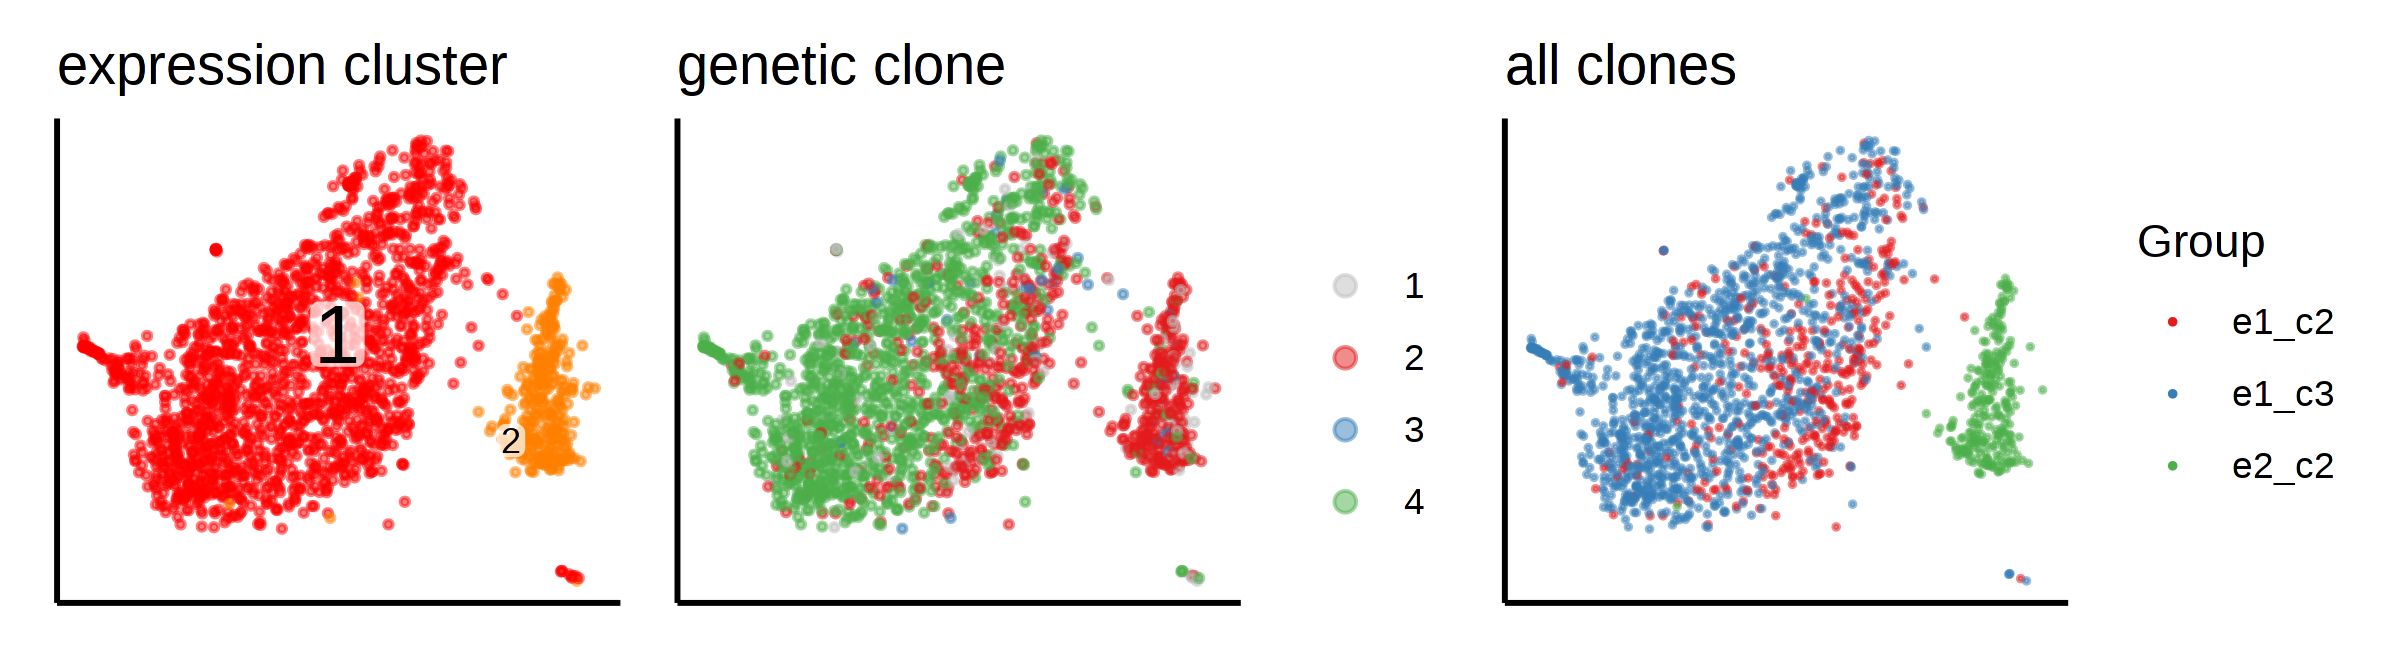

In [482]:
options(repr.plot.width = 8, repr.plot.height = 2.2, repr.plot.res = 300)

con_sample = con$samples[['27522_Primary']]

con_clusters = con_sample$clusters$PCA$multilevel
con_clusters = con_clusters[names(con_clusters) %in% nb$clone_post$cell]
con_clusters[con_clusters %in% c(2,3,8)] = 1
con_clusters[con_clusters %in% c(12)] = 2
con_clusters = con_clusters[con_clusters %in% c(1,2)]

clone_annot = nb$clone_post %>%
#     filter(p_opt > 0.5) %>%
    mutate(cluster = con_clusters[cell]) %>%
    filter(!is.na(cluster))

group_annot = clone_annot %>% 
    mutate(group = case_when(
        cluster == 2 & clone_opt == 2 ~ 'e2_c2',
        cluster == 1 & clone_opt == 2 ~ 'e1_c2',
        cluster == 1 & clone_opt == 4 ~ 'e1_c3'
    )) %>%
    filter(!is.na(group))

p1 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.5, 
    groups = clone_annot %>% {setNames(.$cluster, .$cell)},
    show.legend = F,
    plot.na = F,
    plot.theme = theme_classic(),
    title = 'expression cluster'
) +
guides(color = guide_legend(title = 'cluster'))

p2 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.5, 
    groups = clone_annot %>% {setNames(.$clone_opt, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
    title = 'genetic clone'
) +
guides(color = guide_legend(title = '', override.aes = list(size = 2)))

p3 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = group_annot %>% {setNames(.$group, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = pal[1:3],
    plot.theme = theme_classic(),
    title = 'all clones'
) 

p1 | p2 | p3

#### Cluster 1 vs 2

In [380]:
# cluster1 vs 2
sample = '27522_Primary'

de_annot = clone_annot %>% filter(cluster %in% c(1,2))

con$samples[[sample]]$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$cluster, .$cell)},
    append.auc = T
)

genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 1) > 5]

fold_changes = aggregate_counts(
        count_mat[[sample]][genes,],
        de_annot %>% mutate(group = factor(cluster, c(1,2)))
    ) %>%
    as.matrix %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC))

Warning message in con$samples[[sample]]$getDifferentialGenes(groups = de_annot %>% :
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”


cell_dict
   1    2 
1717  322 


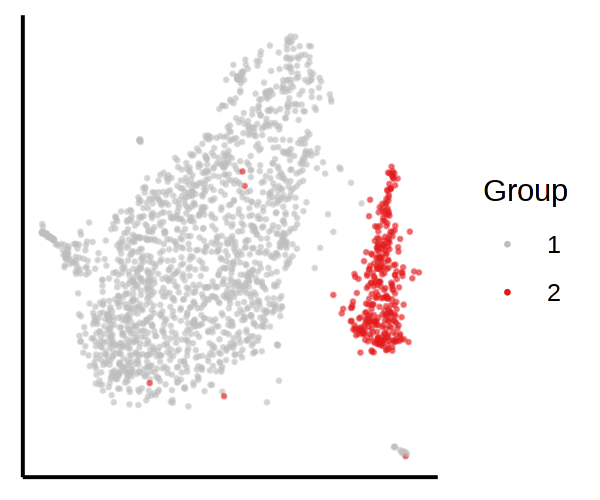

In [381]:
options(repr.plot.width = 3, repr.plot.height = 2.5, repr.plot.res = 200)

con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = de_annot %>% {setNames(droplevels(.$cluster), .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
) 

Warning message:
“ggrepel: 351 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


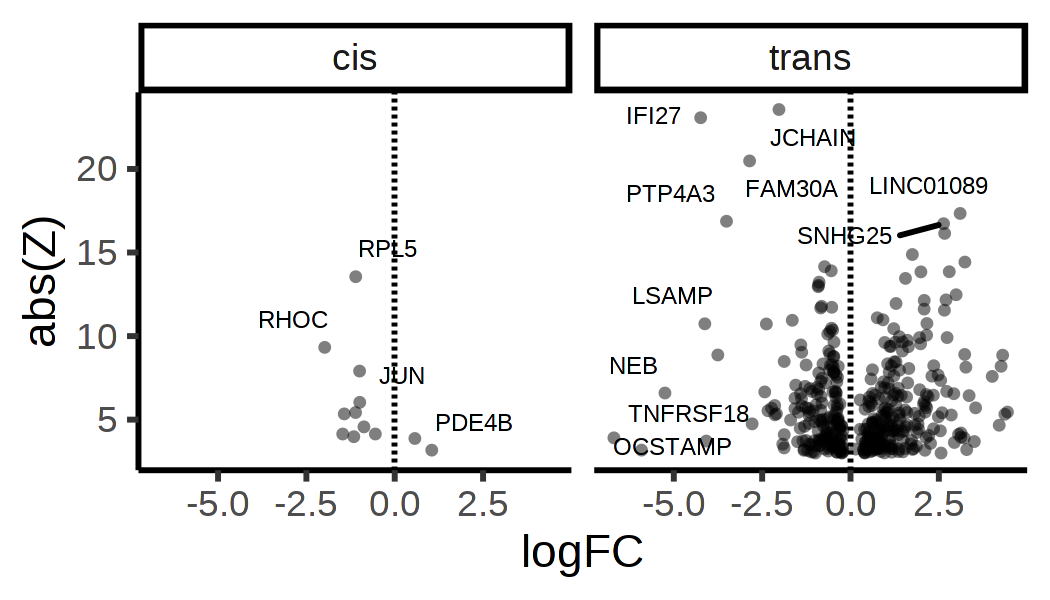

In [385]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 300)

seg_start = 52085411
seg_end = 121518467

DE = con$samples[[sample]]$diffgenes$counts$customClustering[[1]] %>%
    tibble::rownames_to_column('gene') %>%
    inner_join(gtf_hg38, by = 'gene') %>%
    left_join(fold_changes, by = 'gene') %>%
    mutate(loc = ifelse(CHROM == 1 & gene_start < seg_end & gene_end > seg_start, 'cis', 'trans'))

ggplot(
    DE,
    aes(x = logFC, y = abs(Z))
) +
geom_point(size = 1, alpha = 0.5, pch = 16) +
theme_classic() +
scale_color_manual(values = c('gray', 'red')) +
facet_wrap(~loc) +
ggrepel::geom_text_repel(aes(label = gene), size = 2) +
geom_vline(xintercept = 0, linetype = 'dashed')

In [383]:
count_mat_combined = lapply(samples, function(sample) {con$samples[[sample]]$counts}) %>% Reduce('rbind', .)

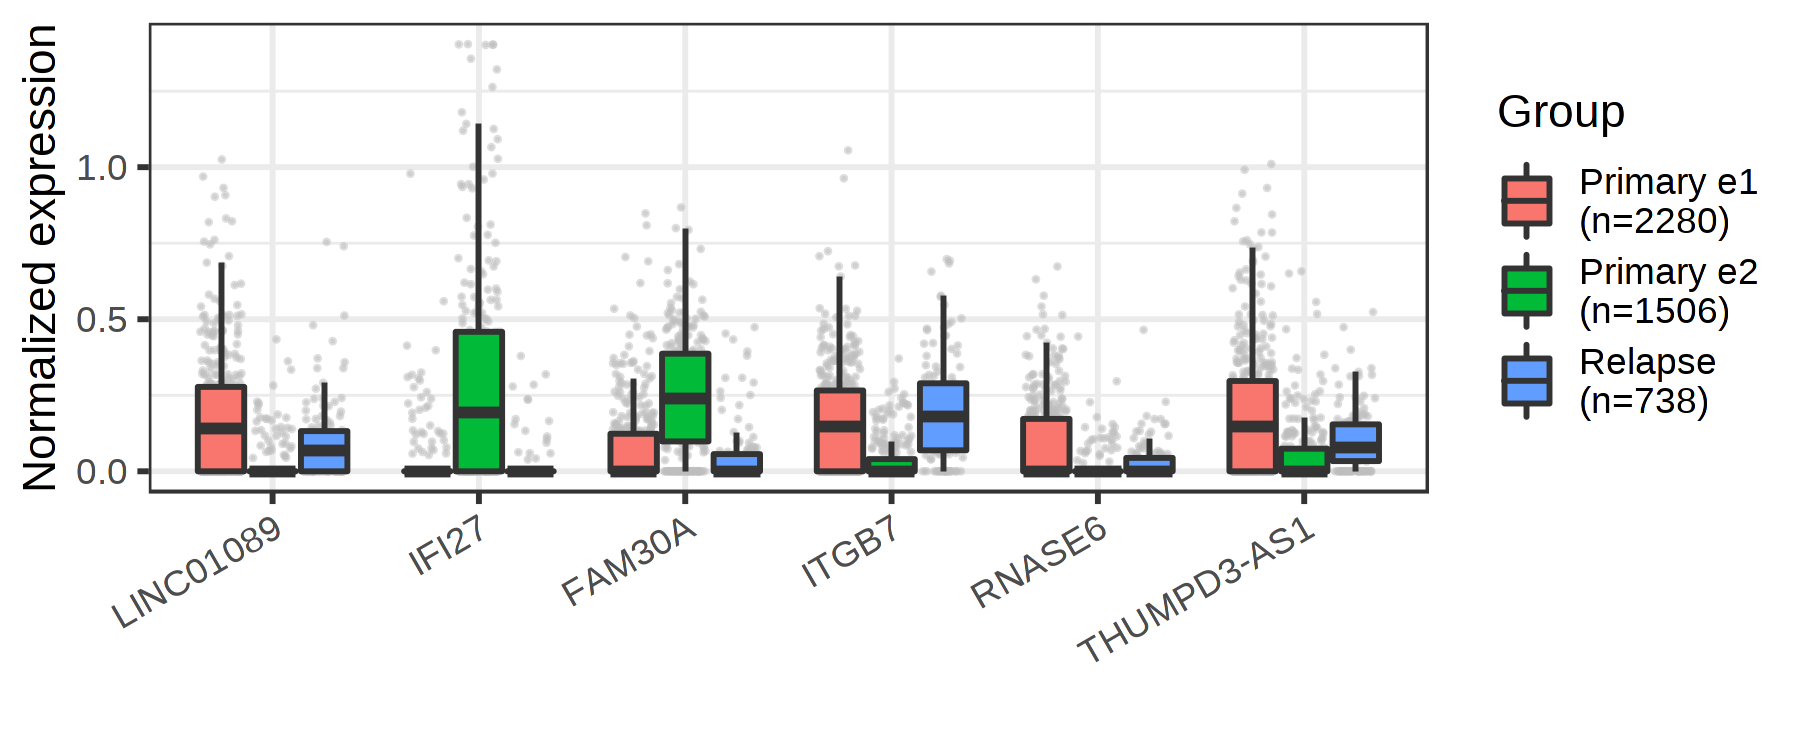

In [389]:
cells = nb$clone_post %>% filter(clone_opt == 2) %>% pull(cell)
markers = DE %>% filter(loc == 'trans') %>% arrange(-AUC) %>% head %>% pull(gene)
D = count_mat_combined[cells, markers] %>%
    as.matrix %>%
    reshape2::melt() %>%
    setNames(c('cell', 'gene', 'exp')) %>%
    left_join(bind_rows(cell_annot[samples]), by = 'cell') %>%
    mutate(
        cluster = ifelse(sample_id == '27522_Primary', con_clusters[as.character(cell)], sample_id)
    ) %>%
    filter(cell_type == 'Plasma') %>%
    filter(cluster %in% c(1,2, c('27522_Relapse_2', '27522_Relapse_1'))) %>%
    mutate(cluster = c('1' = 'Primary e1', '2' = 'Primary e2', '27522_Relapse_2' = 'Relapse', '27522_Relapse_1' = 'Relapse')[cluster]) %>%
    group_by(cluster) %>%
    mutate(n_cluster = n()) %>%
    mutate(cluster = glue('{cluster}\n(n={n_cluster})')) %>%
    ungroup()

set.seed(0)

p = ggplot(
    D,
    aes(x = gene, fill = cluster, y = exp)
) +
geom_jitter(aes(group = cluster), size = 0.1, alpha = 0.5, color = 'gray', position = position_jitterdodge(jitter.width = 0.2)) +
geom_boxplot(outlier.size = 0, outlier.alpha = 0) +
theme_bw() +
theme(
    axis.text.x = element_text(angle = 30, hjust = 1)
) +
xlab('') +
ylab('Normalized expression') +
guides(fill=guide_legend(
    keywidth=0.2,
    keyheight=0.3,
    default.unit="inch",
    title = 'Group')
)

do_plot(p, 'de_markers', 6, 2.5)

#### **Restrict to clone 2**

In [483]:
# cluster1 vs 2
sample = '27522_Primary'

de_annot = group_annot %>% filter(group %in% c('e2_c2', 'e1_c2'))

con$samples[[sample]]$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$group, .$cell)}
)

fold_changes = aggregate_counts(
        count_mat[[sample]],
        de_annot %>% mutate(group = factor(group, c('e2_c2', 'e1_c2')))
    ) %>%
    as.matrix %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC))

Warning message in con$samples[[sample]]$getDifferentialGenes(groups = de_annot %>% :
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”


cell_dict
e2_c2 e1_c2 
  251   380 


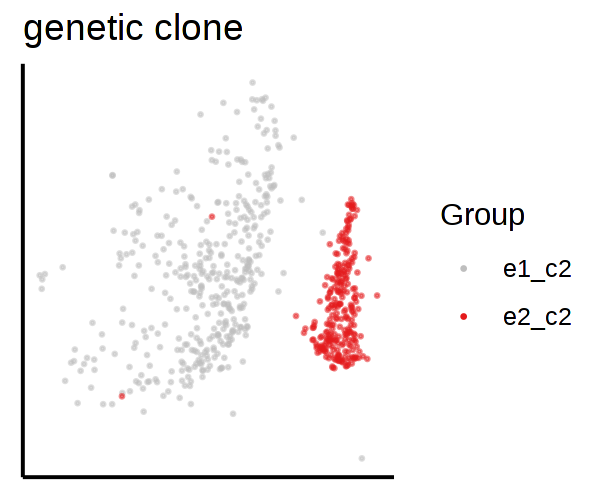

In [363]:
options(repr.plot.width = 3, repr.plot.height = 2.5, repr.plot.res = 200)

con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = de_annot %>% {setNames(factor(.$group), .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
    title = 'genetic clone'
)

In [364]:
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

values = fold_changes %>% 
    filter(gene %in% expressed_genes) %>%
    filter(!is.infinite(logFC)) %>% 
    {setNames(.$logFC, .$gene)}

gsea_out_1 = bulk.gsea(
    values = values,
    set.list = h_gene_sets,
    mc.cores = 10
) %>%
tibble::rownames_to_column('gene.set') %>%
mutate(q.val = p.adjust(p.val, method = 'BH')) 

In [255]:
gsea_out_1 %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(q.val, -sscore)

gene.set                p.val      q.val       sscore    edge     
1 TNFA_SIGNALING_VIA_NFKB 0.00009999 0.000499950 1.5226877 0.8341446
2 CHOLESTEROL_HOMEOSTASIS 0.00119988 0.004285286 1.2469541 0.8341446
3 IL2_STAT5_SIGNALING     0.01179882 0.026815500 0.9889691 1.7186674

In [279]:
options(repr.plot.width = 4.2, repr.plot.height = 3, repr.plot.res = 200)
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

rename_dict = c('TNFA_SIGNALING_VIA_NFKB' = expression(paste("TNF", alpha, " signaling via NF", kappa, "B")))

for (gs in c('TNFA_SIGNALING_VIA_NFKB')) {
    
    pdf(glue('~/figures/{gs}_gsea.pdf'), width = 4.2, 3)
    
    gsea(
        values = fold_changes %>% 
            filter(gene %in% expressed_genes) %>%
            filter(!is.infinite(logFC)) %>%
            {setNames(.$logFC, .$gene)},
        h_gene_sets[[gs]],
        q.val = gsea_out_1 %>% filter(gene.set == gs) %>% pull(q.val),
        main = rename_dict[gs]
    )
    
    dev.off()
    
}

#### **Within cluster clone 2 vs 3**

In [487]:
sample = '27522_Primary'

de_annot = group_annot %>% filter(group %in% c('e1_c2', 'e1_c3'))

con_sample$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$clone_opt, .$cell)}
)

fold_changes = aggregate_counts(
        count_mat[[sample]],
        de_annot %>% mutate(group = factor(clone_opt, c(4,2)))
    ) %>%
    as.matrix %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC))

Warning message in con_sample$getDifferentialGenes(groups = de_annot %>% {:
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”


cell_dict
   4    2 
1230  380 


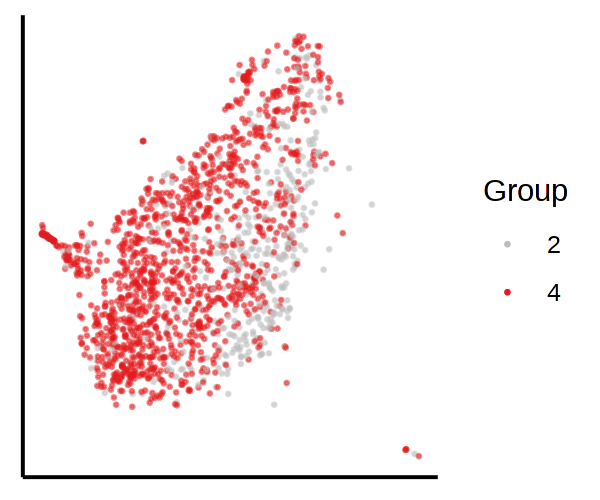

In [461]:
options(repr.plot.width = 3, repr.plot.height = 2.5, repr.plot.res = 200)

con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = de_annot %>% {setNames(.$clone_opt, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
#     title = 'genetic clone'
) 

In [439]:
nb$segs_consensus %>% filter(cnv_state == 'del' & CHROM == 1)

sample CHROM seg cnv_state cnv_state_post seg_start seg_end   seg_start_index
1 4      1     1c  del       del            52085411  146938545 4091           
  seg_end_index theta_mle theta_sigma phi_mle   phi_sigma p_loh        p_del
1 6783          0.4176937 0.004352153 0.5902839 0.035164  5.130406e-13 1    
  p_amp        p_bamp p_bdel LLR      LLR_y   LLR_x    n_genes n_snps component
1 1.208838e-87 0      0      3042.245 1480.64 39.16178 214     1610   1        
  LLR_sample seg_length seg_cons n_states cnv_states
1 1519.801   94853134   1c       0        del

Warning message:
“ggrepel: 125 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


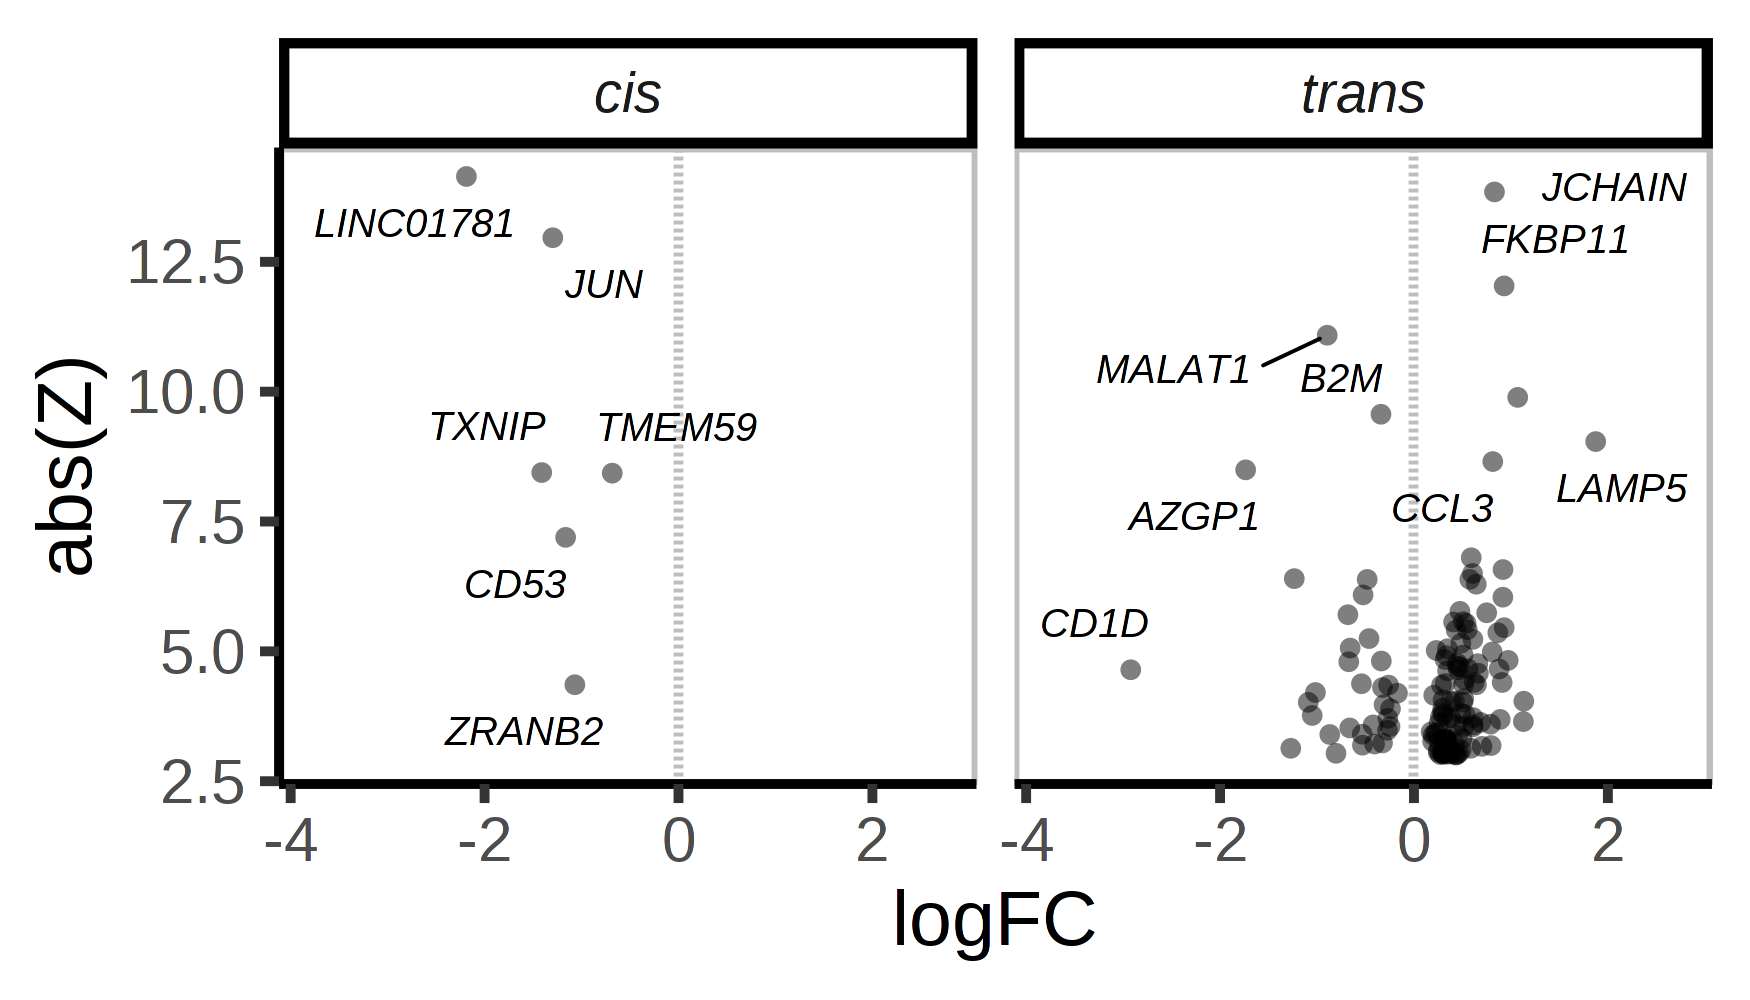

In [463]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 500)

seg_start = 52085411
seg_end = 146938545

DE = con_sample$diffgenes$counts$customClustering[[1]] %>%
    tibble::rownames_to_column('gene') %>%
    inner_join(gtf_hg38, by = 'gene') %>%
    left_join(fold_changes, by = 'gene') %>%
    mutate(
        loc = ifelse(CHROM == 1 & gene_start < seg_end & gene_end > seg_start, 'cis', 'trans')
    )

p_de1 = ggplot(
    DE,
    aes(x = logFC, y = abs(Z))
) +
geom_point(size = 1, alpha = 0.5, pch = 16) +
theme_classic() +
scale_color_manual(values = c('gray', 'red')) +
facet_wrap(~loc) +
geom_vline(xintercept = 0, linetype = 'dashed', color = 'gray') +
geom_text_repel(aes(label = gene), size = 2, max.overlaps = 4, seed = 0, segment.size = 0.2, fontface = 'italic') +
theme(
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_rect(fill = NA, size = 1),
    strip.text = element_text(size = 8, face = 'italic')
) +
scale_x_continuous(expand = expansion(0.25))

p_de1

In [441]:
DE %>% count(loc)

loc   n  
1 cis     6
2 trans 141

In [360]:
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

values = fold_changes %>% 
    filter(gene %in% expressed_genes) %>%
    filter(!is.infinite(logFC)) %>% 
    {setNames(.$logFC, .$gene)}

gsea_out_2 = bulk.gsea(
    values = values,
    set.list = h_gene_sets,
    mc.cores = 10
) %>%
tibble::rownames_to_column('gene.set') %>%
mutate(q.val = p.adjust(p.val, method = 'BH'))

In [489]:
values %>% length

[1] 14778

In [75]:
gsea_out_2 %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(q.val, -sscore)

gene.set                          p.val      q.val       sscore    edge     
1 E2F_TARGETS                       0.00009999 0.000499950 3.3821746 0.2614013
2 G2M_CHECKPOINT                    0.00009999 0.000499950 3.1681556 0.7479921
3 MITOTIC_SPINDLE                   0.00009999 0.000499950 2.1151247 0.6829448
4 SPERMATOGENESIS                   0.00009999 0.000499950 1.4511280 1.4591317
5 ESTROGEN_RESPONSE_LATE            0.00109989 0.004582875 1.2024888 0.5252018
6 EPITHELIAL_MESENCHYMAL_TRANSITION 0.01339866 0.033496650 0.9622081 0.2583549

In [358]:
options(repr.plot.width = 4.2, repr.plot.height = 3, repr.plot.res = 200)

rename_dict = c('E2F_TARGETS' = expression('E2F targets'), 'G2M_CHECKPOINT' = expression('G2M checkpoint'))

for (gs in c('E2F_TARGETS', 'G2M_CHECKPOINT')) {
    
    pdf(glue('~/figures/{gs}_gsea.pdf'), width = 4.2, 3)

    gsea(
        fold_changes %>% 
            filter(gene %in% expressed_genes) %>%
            filter(!is.infinite(logFC)) %>%
            {setNames(.$logFC, .$gene)},
        h_gene_sets[[gs]],
        q.val = gsea_out_2 %>% filter(gene.set == gs) %>% pull(q.val),
        main = rename_dict[gs]
    )
    
    dev.off()
    
}

In [413]:
chrom_sizes = fread('~/ref/hg38.chrom.sizes.txt') %>% 
    setNames(c('CHROM', 'size')) %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>%
    filter(CHROM %in% 1:22) %>%
    mutate(CHROM = factor(CHROM))

genome_size = sum(chrom_sizes$size)

In [445]:
seg_start = 52085411
seg_end = 146938545
region_mb = seg_end - seg_start
genome_size = sum(chrom_sizes$size)

gtf_hg38 %>% filter(gene %in% h_gene_sets[['E2F_TARGETS']])  %>%
count(CHROM == 1 & gene_start > seg_start & gene_end < seg_end) 

gtf_hg38 %>% filter(gene %in% h_gene_sets[['G2M_CHECKPOINT']])  %>%
count(CHROM == 1 & gene_start > seg_start & gene_end < seg_end) 

binom.test(x = 3, n = 193, p = region_mb/genome_size)
binom.test(x = 4, n = 193, p = region_mb/genome_size)

CHROM == 1 & gene_start > seg_start & gene_end < seg_end n  
1 FALSE                                                    190
2  TRUE                                                      3

CHROM == 1 & gene_start > seg_start & gene_end < seg_end n  
1 FALSE                                                    189
2  TRUE                                                      4


	Exact binomial test

data:  3 and 193
number of successes = 3, number of trials = 193, p-value = 0.2251
alternative hypothesis: true probability of success is not equal to 0.03299238
95 percent confidence interval:
 0.003217098 0.044751968
sample estimates:
probability of success 
            0.01554404 



	Exact binomial test

data:  4 and 193
number of successes = 4, number of trials = 193, p-value = 0.5406
alternative hypothesis: true probability of success is not equal to 0.03299238
95 percent confidence interval:
 0.005675156 0.052212409
sample estimates:
probability of success 
            0.02072539 


#### **Clone 2 vs 4**

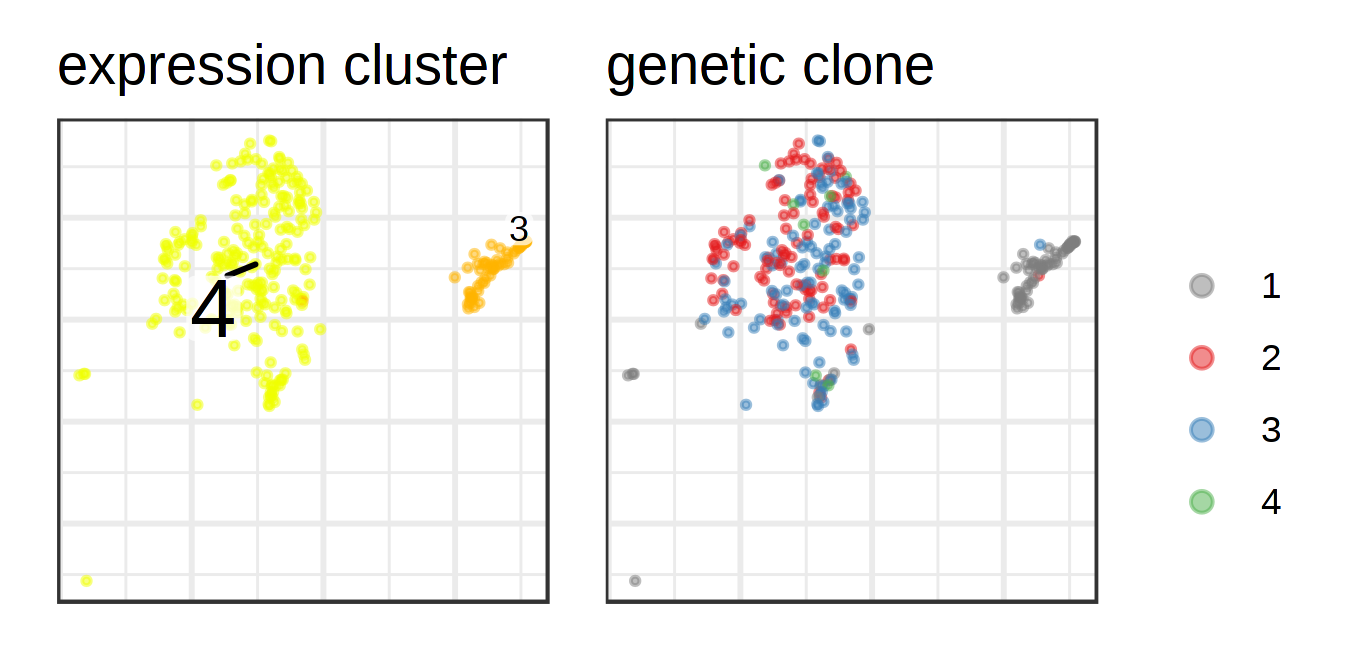

In [490]:
options(repr.plot.width = 4.5, repr.plot.height = 2.2, repr.plot.res = 300)

sample = '27522_Relapse_2'

# expression clusters
con_sample = con$samples[[sample]]

con_clusters = con_sample$clusters$PCA$multilevel
con_clusters = con_clusters[names(con_clusters) %in% nb$clone_post$cell]
con_clusters = con_clusters[con_clusters %in% c(3,4)]

clone_annot = nb$clone_post %>%
    mutate(cluster = con_clusters[cell]) %>%
    filter(!is.na(cluster))

p1 = con_sample$plotEmbedding(
        alpha=0.5,
        size=0.5, 
        groups = con_clusters,
        show.legend = F,
        plot.na = F,
        plot.theme = theme_bw(),
        title = 'expression cluster'
    ) +
    guides(color = guide_legend(title = 'cluster'))

p2 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.5, 
    groups = clone_annot %>% {setNames(.$clone_opt, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray50', pal[1:3]),
    plot.theme = theme_bw(),
    title = 'genetic clone'
) +
guides(color = guide_legend(title = '', override.aes = list(size = 2))) 

p1 | p2

In [452]:
nb$segs_consensus %>% filter(CHROM == 16 & cnv_state == 'del')

sample CHROM seg cnv_state cnv_state_post seg_start seg_end  seg_start_index
1 3      16    16b del       del            31527900  90023620 125583         
  seg_end_index theta_mle theta_sigma phi_mle  phi_sigma  p_loh        p_del
1 128808        0.3924358 0.01198624  0.540445 0.03638552 7.441134e-17 1    
  p_amp        p_bamp        p_bdel        LLR      LLR_y    LLR_x    n_genes
1 1.500379e-72 9.072195e-221 4.406929e-150 379.4321 218.4476 41.89867 182    
  n_snps component LLR_sample seg_length seg_cons n_states cnv_states
1 546    9         260.3463   58495720   16b      0        del

Warning message in con_sample$getDifferentialGenes(groups = de_annot %>% {:
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”


cell_dict
  3   2 
104 100 


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


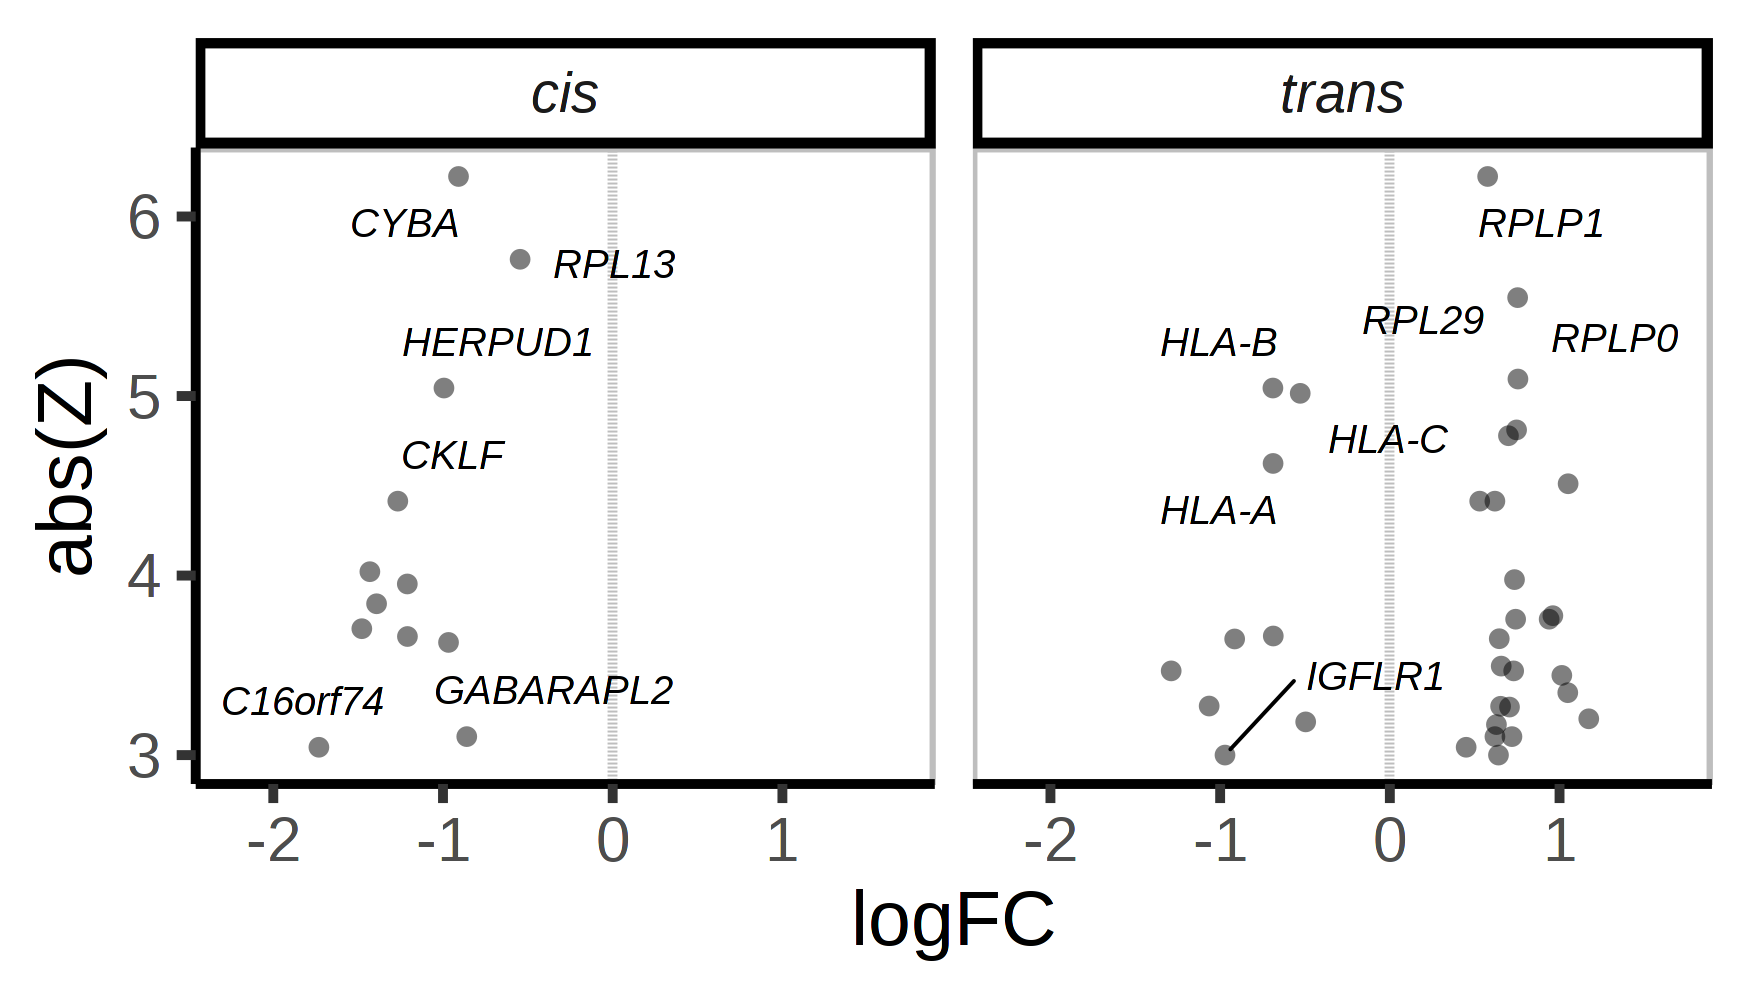

In [493]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 500)

# DE
de_annot = clone_annot %>% filter(clone_opt %in% c(2,3))

con_sample = con$samples[['27522_Relapse_2']]

con_sample$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$clone_opt, .$cell)}
)

fold_changes = aggregate_counts(
        count_mat[[sample]],
        de_annot %>% mutate(group = factor(clone_opt, c(3,2)))
    ) %>%
    as.matrix %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC) & !is.infinite(logFC))

# visualize
seg_start = 31527900
seg_end = 90023620

DE = con_sample$diffgenes$counts$customClustering[[1]] %>%
    tibble::rownames_to_column('gene') %>%
    inner_join(gtf_hg38, by = 'gene') %>%
    left_join(fold_changes, by = 'gene') %>%
    mutate(loc = ifelse(CHROM == 16 & gene_start < seg_end & gene_end > seg_start, 'cis', 'trans'))

p_de2 = ggplot(
    DE,
    aes(x = logFC, y = abs(Z))
) +
geom_point(size = 1, alpha = 0.5, pch = 16) +
theme_classic() +
scale_color_manual(values = c('gray', 'red')) +
facet_wrap(~loc) +
geom_vline(xintercept = 0, linetype = '22', color = 'gray') +
geom_text_repel(aes(label = gene), size = 2, max.overlaps = 4, seed = 0, segment.size = 0.2, fontface = 'italic') +
theme(
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_rect(fill = NA, size = 1),
    strip.text = element_text(size = 8, face = 'italic')
) +
scale_x_continuous(expand = expansion(0.25))

# do_plot(p, 'de2', 3.5, 2)

p_de2

Warning message:
“ggrepel: 133 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 27 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 131 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


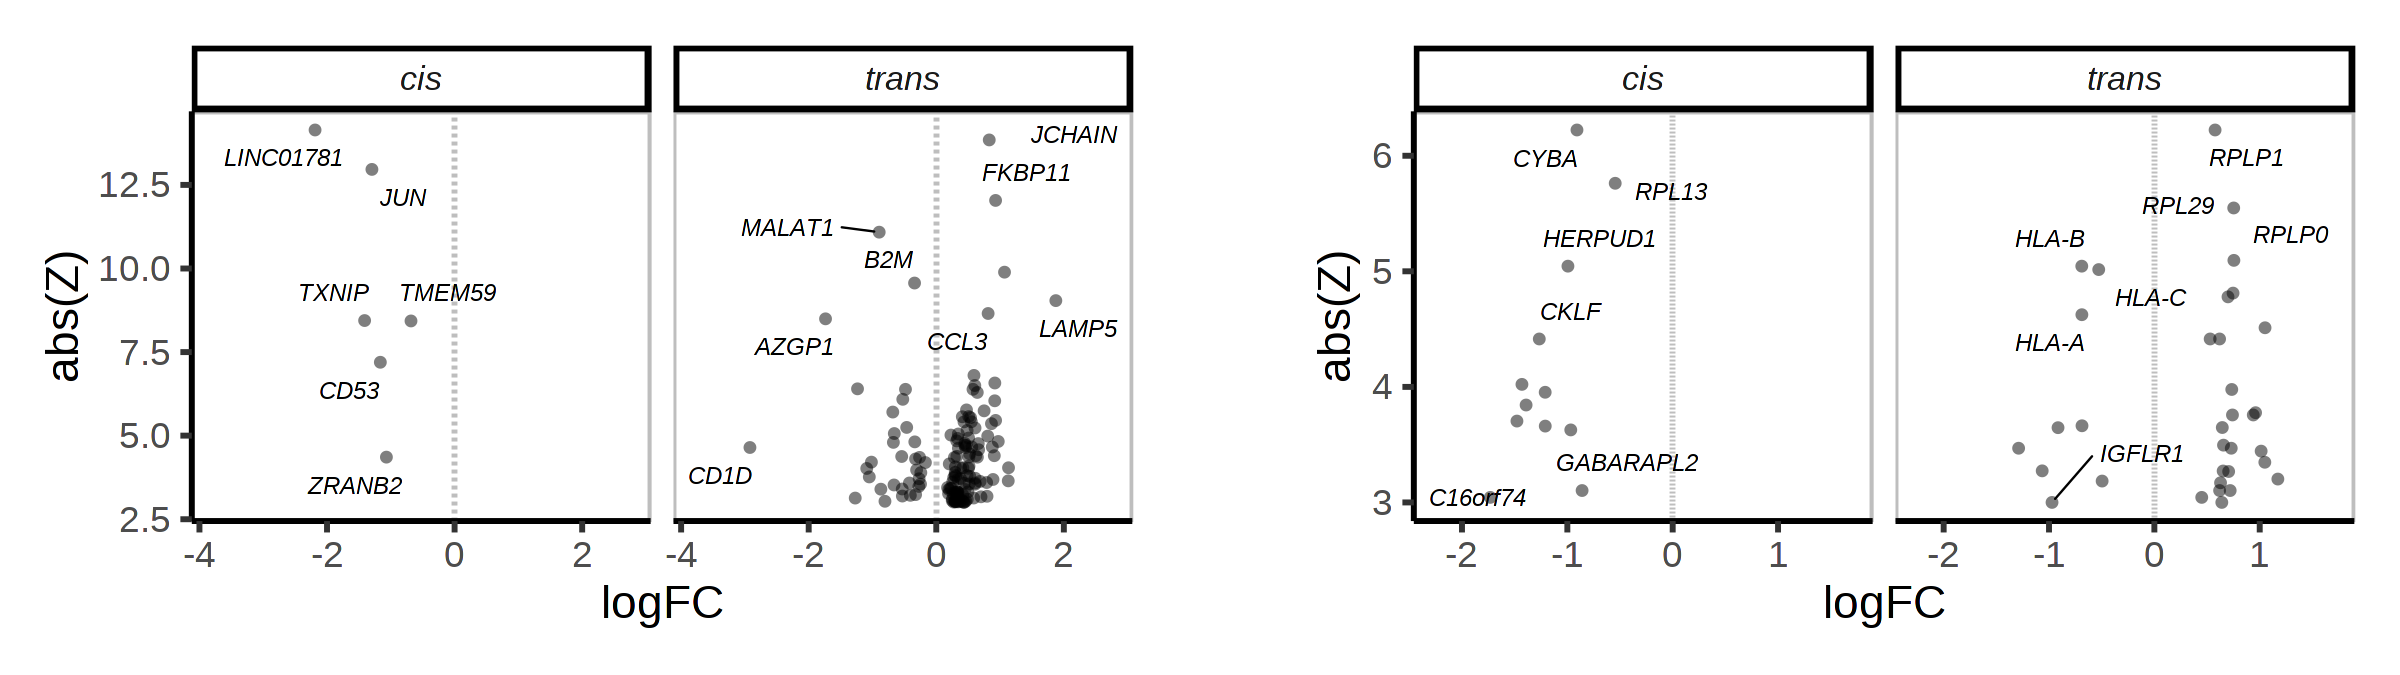

In [475]:
panel = (p_de1 | plot_spacer() | p_de2) + plot_layout(widths = c(10,1,10))
do_plot(panel, 'de_all', 8, 2.25)

In [494]:
DE %>% count(loc)

loc   n 
1 cis   12
2 trans 34

In [497]:
sample = '27522_Relapse_2'

expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

values = fold_changes %>% 
    filter(gene %in% expressed_genes) %>%
    filter(!is.infinite(logFC)) %>% 
    {setNames(.$logFC, .$gene)}

gsea_out_3 = bulk.gsea(
    values = values,
    set.list = h_gene_sets,
    mc.cores = 10
) %>%
tibble::rownames_to_column('gene.set') %>%
mutate(q.val = p.adjust(p.val, method = 'BH'))

In [374]:
gsea_out_3 %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(q.val, -sscore)

gene.set                  p.val     q.val     sscore    edge      
1 INTERFERON_GAMMA_RESPONSE 0.0009999 0.0119988 -1.240737 -0.2941769

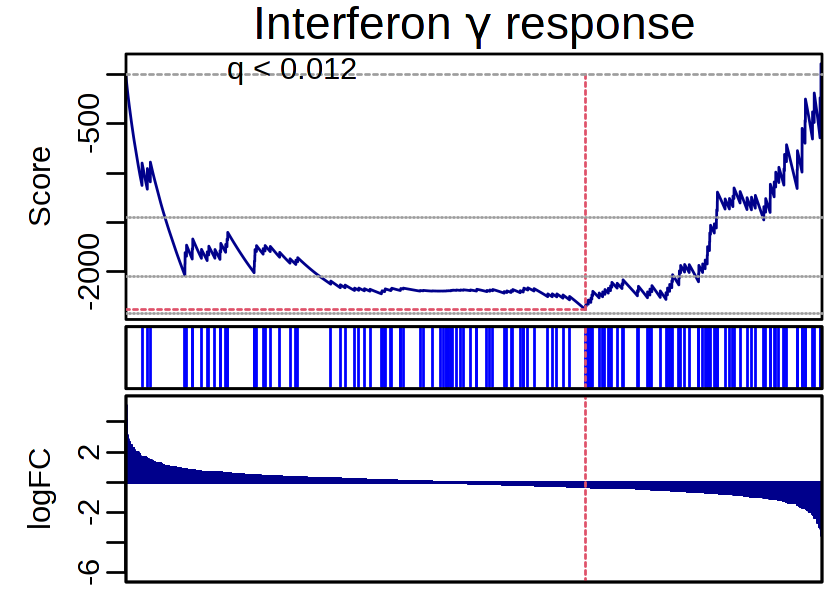

In [289]:
options(repr.plot.width = 4.2, repr.plot.height = 3, repr.plot.res = 200)

rename_dict = c('INTERFERON_GAMMA_RESPONSE' = expression(paste('Interferon ', gamma, ' response')))

for (gs in c('INTERFERON_GAMMA_RESPONSE')) {

    gsea(
        values = fold_changes %>% 
            filter(gene %in% expressed_genes) %>%
            filter(!is.infinite(logFC)) %>%
            {setNames(.$logFC, .$gene)},
        h_gene_sets[[gs]],
        ypos = 'top',
        q.val = gsea_out_3 %>% filter(gene.set == gs) %>% pull(q.val),
        main = rename_dict[gs]
    )
    
}

In [455]:
seg_start = 31527900
seg_end = 90023620

gtf_hg38 %>%
filter(gene %in% h_gene_sets[['INTERFERON_GAMMA_RESPONSE']]) %>%
count(CHROM == 16 & gene_start > seg_start & gene_end < seg_end)

region_mb = seg_end - seg_start
prop.test(x = 5, n = 200, p = region_mb/genome_size)

CHROM == 16 & gene_start > seg_start & gene_end < seg_end n  
1 FALSE                                                     195
2  TRUE                                                       5

Warning message in prop.test(x = 5, n = 200, p = region_mb/genome_size):
“Chi-squared approximation may be incorrect”



	1-sample proportions test with continuity correction

data:  5 out of 200, null probability region_mb/genome_size
X-squared = 0.046541, df = 1, p-value = 0.8292
alternative hypothesis: true p is not equal to 0.02034633
95 percent confidence interval:
 0.009239825 0.060555676
sample estimates:
    p 
0.025 


## GSEA table

In [390]:
rbind(
    gsea_out_1 %>% mutate(comparison = 'e2g1 vs e1g1', .before = 1),
    gsea_out_2 %>% mutate(comparison = 'e1g2 vs e1g1', .before = 1),
    gsea_out_3 %>% mutate(comparison = 'e1g3 vs e1g1', .before = 1)
) %>%
mutate(comparison = factor(comparison, unique(comparison))) %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(comparison, q.val, -sscore)

comparison   gene.set                          p.val      q.val      
1  e2g1 vs e1g1 TNFA_SIGNALING_VIA_NFKB           0.00009999 0.000499950
2  e2g1 vs e1g1 CHOLESTEROL_HOMEOSTASIS           0.00119988 0.004285286
3  e2g1 vs e1g1 IL2_STAT5_SIGNALING               0.01179882 0.026815500
4  e1g2 vs e1g1 E2F_TARGETS                       0.00009999 0.000499950
5  e1g2 vs e1g1 G2M_CHECKPOINT                    0.00009999 0.000499950
6  e1g2 vs e1g1 MITOTIC_SPINDLE                   0.00009999 0.000499950
7  e1g2 vs e1g1 SPERMATOGENESIS                   0.00009999 0.000499950
8  e1g2 vs e1g1 ESTROGEN_RESPONSE_LATE            0.00109989 0.004582875
9  e1g2 vs e1g1 EPITHELIAL_MESENCHYMAL_TRANSITION 0.01339866 0.033496650
10 e1g3 vs e1g1 INTERFERON_GAMMA_RESPONSE         0.00099990 0.011998800
   sscore     edge      
1   1.5226877  0.8341446
2   1.2469541  0.8341446
3   0.9889691  1.7186674
4   3.3821746  0.2614013
5   3.1681556  0.7479921
6   2.1151247  0.6829448
7   1.4511280  1.4591317
8   1.2024888  0.5252018
9   0.9622081  0.2583549
10 -1.2407375 -0.2941769

In [106]:
rbind(
    gsea_out_1 %>% mutate(comparison = 'e2g1 vs e1g1', .before = 1),
    gsea_out_2 %>% mutate(comparison = 'e1g2 vs e1g1', .before = 1),
    gsea_out_3 %>% mutate(comparison = 'e1g3 vs e1g1', .before = 1)
) %>%
mutate(comparison = factor(comparison, unique(comparison))) %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(comparison, q.val, -sscore) %>%
mutate(gene.set = str_replace_all(gene.set, '_', ' ')) %>%
rename(`Gene set` = gene.set, Comparison = comparison, `P value` = p.val, `Q value` = q.val, `Enrichment score` = sscore, `Edge value` = edge) %>%
fwrite('~/paper_data/GSEA.tsv', sep = '\t')

## tSNE panel

Warning message:
“Removed 66 rows containing missing values (geom_point).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 66 rows containing missing values (geom_point).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


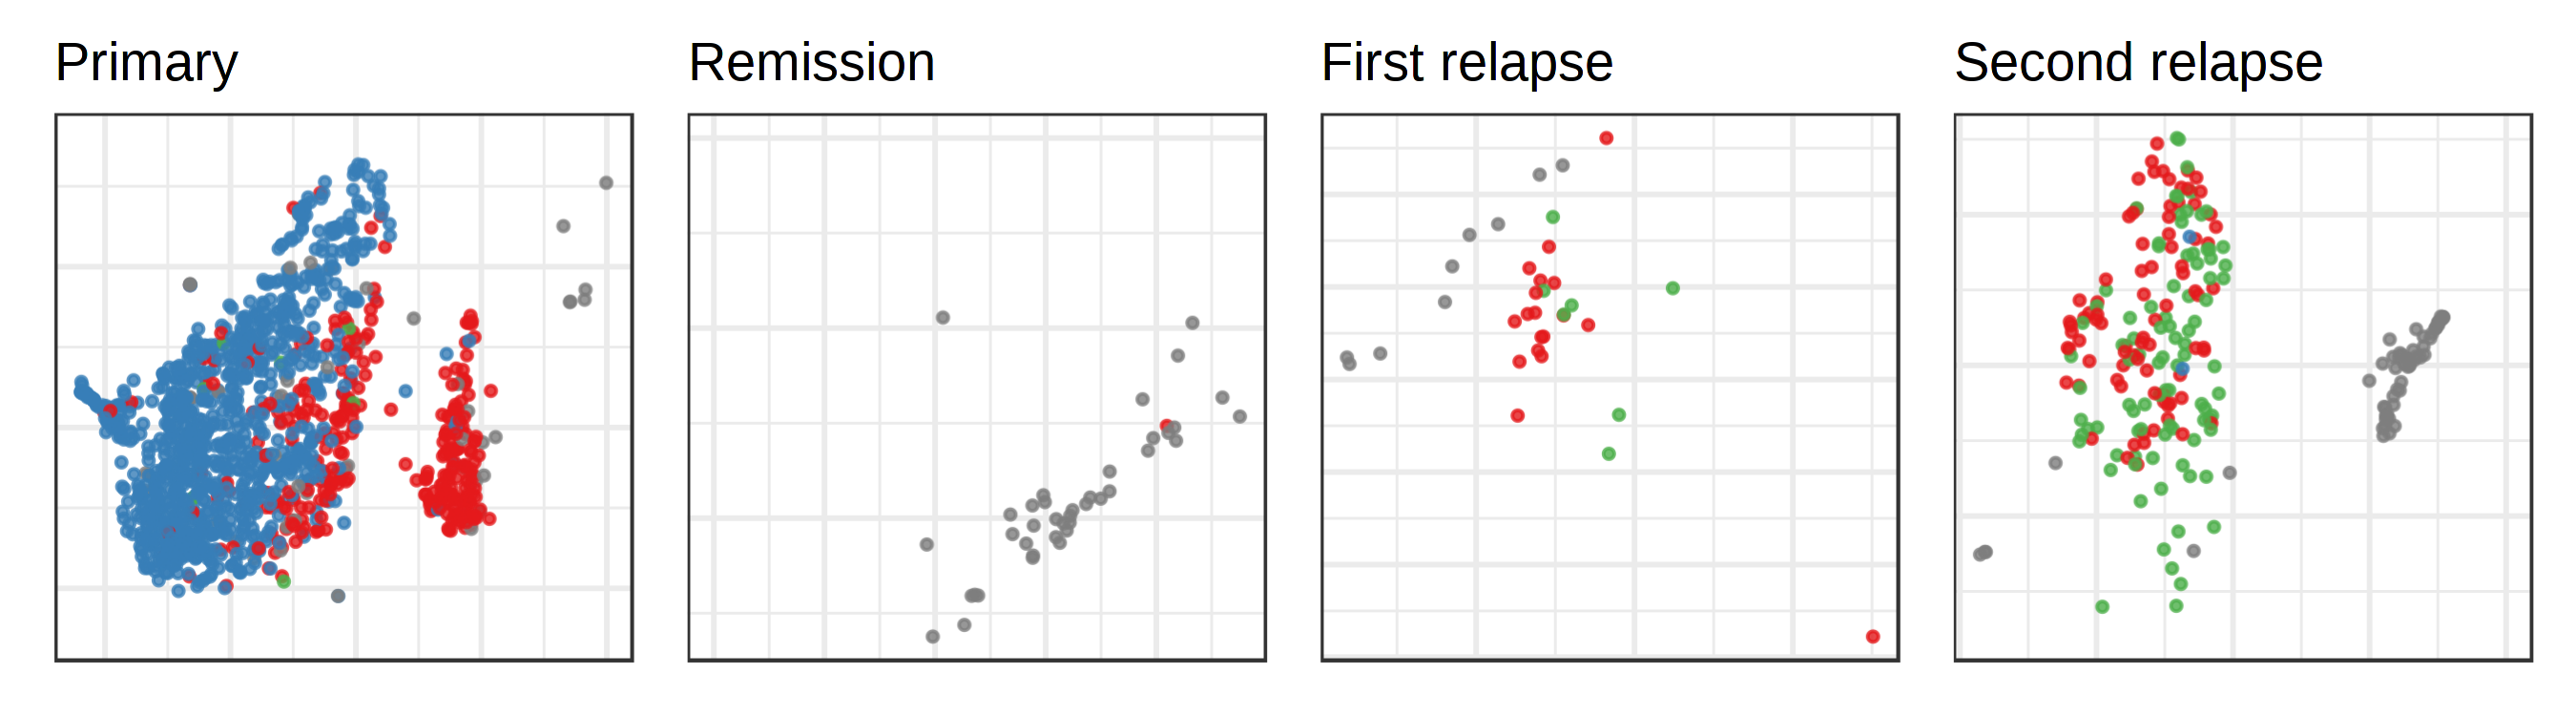

In [172]:
options(repr.plot.width = 9, repr.plot.height = 2.5, repr.plot.res = 300)

size = 0.8
alpha = 0.8
p_min = 0.9

sample = '27522_Primary'
clone_pal = c('gray50', pal[1], pal[3], pal[2])

p1 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = clone_pal,
    groups = nb$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    raster = TRUE,
    title = 'Primary'
) +
# theme_bw() +
xlim(NA, 10) +
ylim(-13, 18) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))


sample = '27522_Remission'

p2 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = clone_pal,
    groups = nb$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    raster = TRUE,
    title = 'Remission'
) +
# theme_bw() +
ylim(NA, -25) +
xlim(-16, NA) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))

sample = '27522_Relapse_1'

p3 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = clone_pal,
    groups = nb$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    raster = TRUE,
    title = 'First relapse'
) +
# xlim(27, NA) +
# ylim(-10, NA) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))

sample = '27522_Relapse_2'

p4 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = clone_pal,
    groups = nb$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    raster = TRUE,
    title = 'Second relapse'
) +
# theme_bw() +
xlim(NA, 20) +
ylim(33, NA) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))

panel = (p1 | p2 | p3 | p4)

do_plot(panel, 'serial_tsne', 9, 2.5)

### Clonal dynamics

In [102]:
 nb$clone_post %>%
    mutate(clone_opt = c('1' = 1, '2' = 2, '3' = 4, '4' = 3)[clone_opt]) %>%
    count(clone_opt)

clone_opt n   
1 1          316
2 2          755
3 3         1264
4 4          149

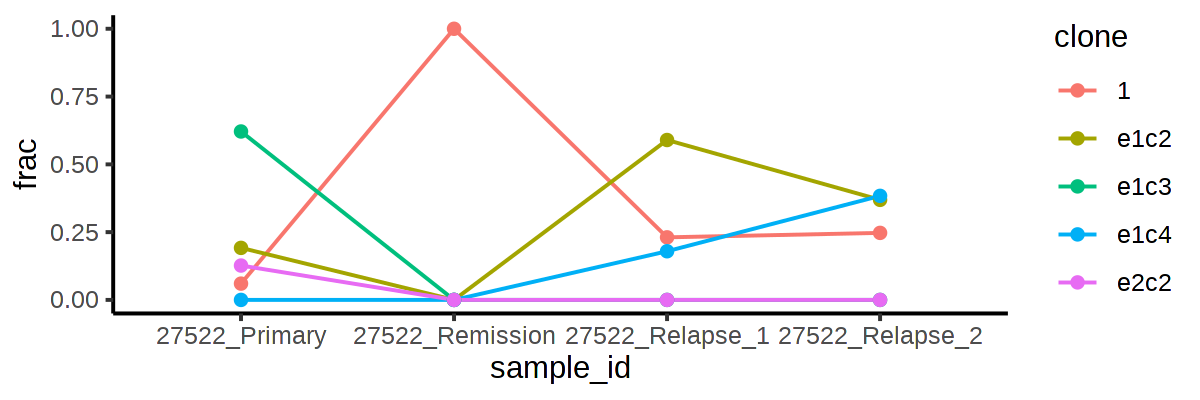

In [174]:
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 200)

con_clusters = con$samples[['27522_Primary']]$clusters$PCA$multilevel
con_clusters = con_clusters[names(con_clusters) %in% nb$clone_post$cell]
con_clusters[con_clusters %in% c(2,3,8)] = 1
con_clusters[con_clusters %in% c(12)] = 2
con_clusters = con_clusters[con_clusters %in% c(1,2)]

frac_table = nb$clone_post %>%
    mutate(clone_opt = c('1' = 1, '2' = 2, '3' = 4, '4' = 3)[clone_opt]) %>%
    mutate(clone = factor(clone_opt)) %>%
    mutate(cluster = con_clusters[cell]) %>%
    inner_join(bind_rows(cell_annot[samples]), by = 'cell') %>%
    mutate(sample_id = factor(sample_id, samples)) %>%
    mutate(clone = ifelse(sample_id == '27522_Primary' & clone != 1, paste0('e', cluster, 'c', clone), clone)) %>%
    mutate(clone = ifelse(sample_id != '27522_Primary' & clone != 1, paste0('e1c', clone), clone)) %>%
    filter(!(sample_id == '27522_Primary' & is.na(cluster))) %>%
    count(sample_id, clone) %>%
    group_by(sample_id) %>%
    mutate(frac = n/sum(n)) %>%
    filter(frac > 0.05) %>%
    mutate(frac = n/sum(n)) %>%
    ungroup() %>%
    tidyr::complete(sample_id, clone, fill = list('n' = 0, 'frac' = 0)) 

frac_table %>%
ggplot(
    aes(x = sample_id, y = frac, color = clone, group = clone)
) +
theme_classic() +
geom_line() +
geom_point()

In [230]:
timepoints = setNames(c(0, 1.1, 2.85, 3.15), str_remove(samples, '27522_'))      

frac_table_wide = frac_table %>%
    reshape2::dcast(clone ~ sample_id, value.var = 'frac') %>%
    tibble::column_to_rownames('clone') %>%
    as.matrix

frac_trunc = colSums(frac_table_wide[2:5,]) + 1e-6
frac_c2 = colSums(frac_table_wide[2:4,])
# frac_table_wide['e1c3',] = frac_table_wide['e1c3',] + 1e-6

frac_table_wide[2,] = frac_c2
frac_table_wide = frac_table_wide %>% rbind(frac_trunc)

parents = c(0,6,2,2,6,0)

In [247]:
options(repr.plot.width = 6, repr.plot.height = 3.2, repr.plot.res = 300)

pal = RColorBrewer::brewer.pal(n = 8, 'Set1')
frac_table_wide[,'27522_Remission'] = c(1, 1e-6, 0, 0, 0, 2e-6)

fish = fishplot::createFishObject(
    frac_table_wide[2:6,] * 100, 
    c(5, 1, 1, 5, 0),
    timepoints = timepoints, 
    col = c(pal[1], pal[2:3], pal[1], pal[1]),
    clone.annots = c('e1', '', '16q-', 'e2', '13-,22-')
)

#calculate the layout of the drawing
fish = fishplot::layoutClones(fish)

dev.off()
pdf('~/figures/fishplot.pdf', width=6, height=3.2)

fishplot::fishPlot(
#     ramp.angle = 1,
    fish,
    shape="spline",
    vlines = timepoints,
#     vlab = names(timepoints),
    cex.vlab = 0.4,
    bg.col = 'white',
    bg.type = 's',
#     border = 0.9,
    col.border = 'black',
    col.vline = 'black'
)

pdf 
  3

[1] "WARNING: there were not 3 background gradient colors set - falling back to defaults"


In [476]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] liger_2.0.1        numbat_0.1.3       testthat_3.0.4     ggtree_3.0.4      
 [5] ggridges_0.5.3     igraph_1.2.11      IRdisplay_1.0      ggrepel_0.9.1     
 [9] extraDistr_1.9.1   tidygraph_1.2.0    ggraph_2.0.5       ggpubr_0.4.0      
[13] magrit